# Data analysis techniques - individual project
# Carmel Gafa

<div class="alert alert-block alert-success">


## Some background - what we are talking about

​The `Arousal-Valence Model` is a visual framework that organizes emotions based on arousal (ranging from calm to agitated) and valence (ranging from negative to positive). By pinpointing one's position within this matrix, individuals can better understand their emotional states, enhancing both emotional and bodily awareness. This tool is particularly beneficial for neurodivergent individuals who may face challenges in identifying and regulating emotions, as it bridges the gap between physical sensations and emotional recognition. ​

Visual aids like the `Arousal-Valence Model` are instrumental in improving emotional intelligence, especially for those with neurodivergent traits such as ADHD or autism. These individuals often experience heightened levels of alexithymia, making it difficult to label and process emotions. By utilizing visual tools, they can more effectively recognize patterns in their emotional experiences and identify triggers that lead to specific responses. This approach not only aids in emotional identification but also supports the development of coping strategies, ultimately fostering better emotional regulation and well-being. ​


<div>
<img src="img/img-arousal-valence.png" width="500"/>
</div>
<sup><sup>Image taken from [1]</sup></sup>


### Mel frequency cepstral co-efficients

 One of the most widely used features in speech processing is the Mel Frequency Cepstral Coefficients (MFCCs).

MFCCs represent the short-term power spectrum of an audio signal and are designed to mimic how humans perceive sound. The key idea is to capture the spectral envelope of speech — essentially how the vocal tract is shaped during speech production — which plays a crucial role in conveying emotion. The MFCC extraction pipeline is as follows:

<div>
<img src="img/img-mfcc.webp" width="500"/>
</div>
<sup><sup>Image taken from [2]</sup></sup>

We can see that the pipeline consists of a number of stages:

- Framing & Windowing: The audio signal is split into short overlapping frames (e.g. 25 ms) to capture stationarity.
- Fast Fourier Transform: Converts each frame from the time domain to the frequency domain.
- Mel Filter Bank: Applies a set of filters spaced according to the Mel scale, which better reflects human auditory perception.
- Log Energy: Emphasizes low-energy components and simulates how humans perceive loudness.
- Discrete Cosine Transform: Used to decorrelate and compress the filterbank energies into a small number of coefficients — the MFCCs.

MFCC are important because they

- Capture the timbre and articulation of speech — features that are sensitive to emotional variation.
- They are particularly informative when a speaker is:
    - Speaking fast or loud (high arousal)
    - Speaking in a soft or relaxed tone (low arousal)
    - Using a positive or negative tone (affecting valence)

MFCCs do not explicitly model prosodic features such as:

- Pitch (F0)
- Intensity (energy)
- Speech rate or rhythm

These features can also be strong indicators of emotion, so MFCCs are sometimes combined with other features such as pitch and intensity.

The dataset includes 130 acoustic features extracted using the openSMILE toolkit, commonly used for speech analysis. These features capture multiple sound characteristics of the speech signal, such as tone, intensity, and rhythm. The 130 features include:

- MFCCs
    - Static coefficients: `mfcc_sma[1]` to `mfcc_sma[14]`
    - Dynamic (delta) coefficients: `mfcc_sma_de[1]` to `mfcc_sma_de[14]`
- Spectral descriptors
    - Includes spectral centroid, roll-off, entropy, variance, skewness, and slope — describing tone and sharpness.
- Prosodic features:
    - Includes pitch (F0), jitter, shimmer, and voicing probability — related to intonation and vocal stability.
- Energy-based features:
    - Includes RMS energy, log harmonic-to-noise ratio (logHNR), and zero-crossing rate — reflecting loudness and clarity.
- Filterbank energies:
    - `audSpec_Rfilt_sma[0–25]` and their delta derivatives — capturing frequency-band-specific energy profiles.
- Psychoacoustic measures:
    - Includes sharpness, harmonicity, and auditory spectrum length — modeling how humans perceive sound.

Each feature ends with `_amean`, indicating it is the mean value computed over a 3-second analysis window, after being extracted frame-by-frame (~25 ms windows with 10 ms hop).

---

**Sources**
 1. https://neurodivergentinsights.com/arousal-valence-model/
 2. https://medium.com/prathena/the-dummys-guide-to-mfcc-aceab2450fd
 3. https://stackoverflow.com/questions/13810873/mfcc-13-coefficients
 4. https://opus.bibliothek.uni-augsburg.de/opus4/frontdoor/deliver/index/docId/77173/file/77173.pdf

</div>

In [2]:
# imports

import pandas as pd
import numpy as np
import os
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

<div class="alert alert-block alert-success">


## Preamble - Loading the data and initial inspection to get acquainted with the data

The data is uploaded and inspected in this stage. The following steps are carried out:

- The data is loaded into a pandas dataframe
- A summary of the data is created and saved in a file. It contains:
    - Feature name
    - Non-null count . It was noted that **all records** contained 7238 non-null values
    - Data type. It was noted that the `participant` feature is an integer, while all other features are floats. The response variables are also floats.
- An additional summary is created that shows the 10 features with the highest number of non-null values was carried out. This served as a second check that the dataset did not contain any missing records

### An initial look at the target values

- We start by examining the distributions of the two response variables, `median_arousal` and `median_valence`. We note that the distribution of `median_arousal` is skewed to the left, while the distribution of `median_valence` is skewed to the right.
- We examine the descriptive statistics of the two response variables. We note that for 
    - `median_arousal` 
        - the mean is 0.010609
        - the skewness is -0.424667, indicating that the distribution is skewed to the left
        - the kurtosis is  -0.260799, indicating that the distribution is slightly platykurtic, that is, it is flatter than a normal distribution
    - `median_valence`
        - the mean is 0.083961.
        - the skewness is 0.698025, indicating that the distribution is skewed to the right
        - the kurtosis is 0.192967, indicating that the distribution is slightly leptokurtic, that is, it is more peaked than a normal distribution
- We finally plot `median_arousal` vs `median_valence` scatter plot to identify the relationship between the two predictors. 
    - The data shows a somewhat positive trend between the predictors although possibly not linear. 


</div>

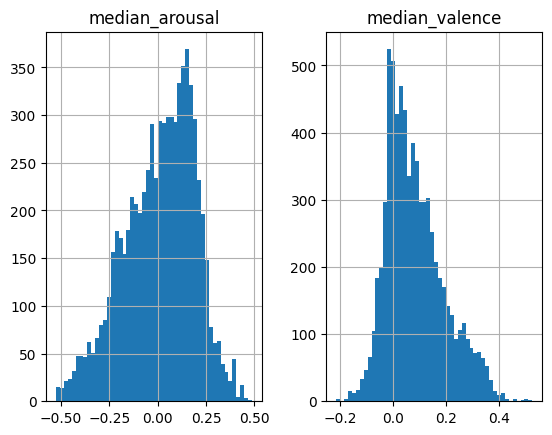

desccriptive statistics of arousal and valence:
-----------------------------------------------
       median_arousal  median_valence
count     7238.000000     7238.000000
mean         0.010609        0.083961
std          0.182776        0.109831
min         -0.526533       -0.214067
25%         -0.115183        0.001067
50%          0.034000        0.063900
75%          0.149317        0.147383
max          0.487000        0.526133
skewness of arousal and valence:
--------------------------------
median_arousal   -0.424667
median_valence    0.698025
dtype: float64
kurtosis of arousal and valence:
--------------------------------
median_arousal   -0.260799
median_valence    0.192967
dtype: float64


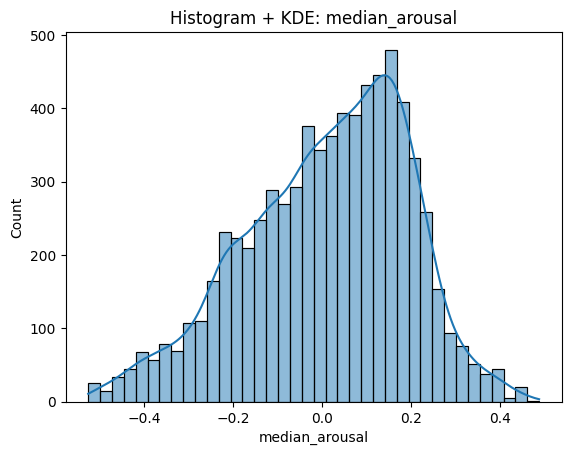

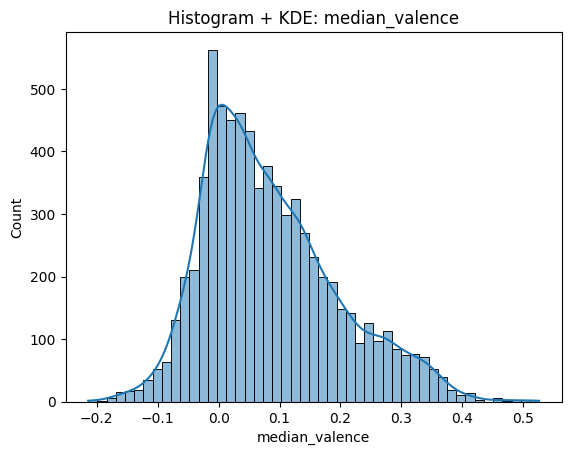

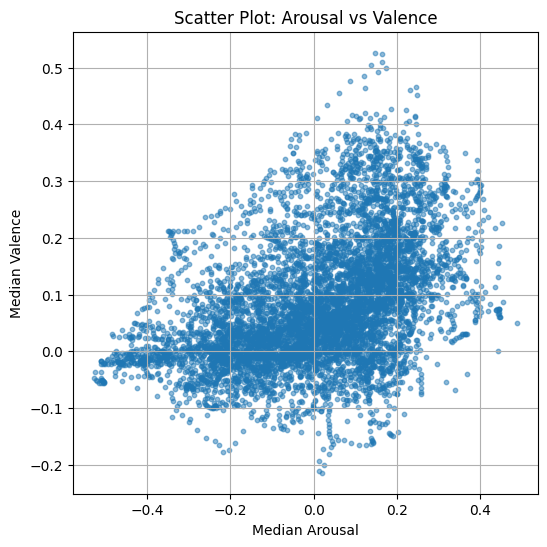

In [3]:
data_folder = 'data/'
data_filename = 'project_data.csv'

data_path = os.path.join(data_folder, data_filename)
df_raw = pd.read_csv(data_path, sep=',', header=0, encoding='utf-8')

# print(df_raw.head())


df_summary = pd.DataFrame({
    'Feature': df_raw.columns,
    'Non-Null Count': df_raw.notnull().sum().values,
    'Data Type': df_raw.dtypes.values
})

# just to be certain about non nulls
df_raw.isnull().sum().sort_values(ascending=False).head(10)


### An initial look at the target values
### ------------------------------------

df_raw[['median_arousal', 'median_valence']].hist(bins=50)
plt.show()

print('desccriptive statistics of arousal and valence:')
print('-----------------------------------------------')
print(df_raw[['median_arousal', 'median_valence']].describe())
print('skewness of arousal and valence:')
print('--------------------------------')
print(df_raw[['median_arousal', 'median_valence']].skew())
print('kurtosis of arousal and valence:')
print('--------------------------------')
print(df_raw[['median_arousal', 'median_valence']].kurt())


### Histograms of predictors

for col in ['median_arousal', 'median_valence']:
    sns.histplot(df_raw[col], kde=True)
    plt.title(f"Histogram + KDE: {col}")
    plt.show()

### relationships between predictors


plt.figure(figsize=(6, 6))
plt.scatter(df_raw['median_arousal'], df_raw['median_valence'], alpha=0.5, s=10)
plt.xlabel('Median Arousal')
plt.ylabel('Median Valence')
plt.title('Scatter Plot: Arousal vs Valence')
plt.grid(True)
plt.show()



<div class="alert alert-block alert-info">

## Task 1
**If you were asked to build a model for predicting arousal and valence, using the provided audio
features as explanatory variables:**

### Which performance metrics would you use to evaluate your model’s predictions?
</div>

<div class="alert alert-block alert-success">


As the labels in this exercise, `median_arousal` and `median_valence` are present and are continuous variables, we are dealing with a supervised regression task.

In these cases, the cost function, which aggregates the individual loss functions across the dataset, can be used as it provides a single scalar value representing the model's overall performance on all training samples. It can be calculated as

$$
\frac{1}{m}\sum_{i=1}^{m} \mathcal{L}(\widehat{y}, y)
$$

There are many different cost functions, but in this exercise, the Mean Square Error will be used;
$$
MSE = \frac{\sum_{i=1}^{n} ( \hat{y}^{(i)}-y^{(i)} )^{2} }{n}
$$

Mean square error (MSE) diminishes the effect of negligible residuals and amplifies the larger residuals. MSE is, however, sensitive to outliers, so for this reason, the outliers' situation is first very briefly evaluated using the following code that ranks the number of outliers per feature:

</div>

In [4]:
from scipy.stats import zscore
z_scores = df_raw.drop(columns=['Participant', 'median_arousal', 'median_valence']).apply(zscore)
outlier_counts = (z_scores.abs() > 3).sum().sort_values(ascending=False)
print(outlier_counts)

ComParE13_LLD_25Hz_audSpec_Rfilt_sma_de[25]_amean         198
ComParE13_LLD_25Hz_audSpec_Rfilt_sma_de[24]_amean         194
ComParE13_LLD_25Hz_audSpec_Rfilt_sma_de[22]_amean         189
ComParE13_LLD_25Hz_audSpec_Rfilt_sma_de[23]_amean         186
ComParE13_LLD_25Hz_pcm_Mag_spectralSlope_sma_de_amean     184
                                                         ... 
ComParE13_LLD_25Hz_mfcc_sma[12]_amean                      20
ComParE13_LLD_25Hz_mfcc_sma[14]_amean                      20
ComParE13_LLD_25Hz_mfcc_sma_de[1]_amean                    19
ComParE13_LLD_25Hz_audspecRasta_lengthL1norm_sma_amean     17
ComParE13_LLD_25Hz_mfcc_sma[2]_amean                       10
Length: 130, dtype: int64


<div class="alert alert-block alert-success">


As the proportion of outliers is modest, it is acceptable to proceed with MSE as a primary performance metric. However there are additional nuisances related to outliers, such as the skewness of the distributions of the features. This factor is not considered at this stage, but, if MAE will give inconsistent results because of the outliers an alternative metric like Mean Absolute Error will be used. 

$$MAE = \frac{\sum_{i=1}^{n} | \hat{y}_i-y_i | }{n}$$

Mean absolute error is often used where the data being considered contains outliers as it is less sensitive to large deviations when compared to other cost functions like the mean square error.

An additional metric that will be used in this case is the Coefficient of Determination ($R^2$) that measures the proportion of variance in $y$ explained by the model. This metric ranges from $-\infty$ to 1.

$$R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}
$$

- $R^2 = 1$: perfect fit
- $R^2 = 0$: model does no better than mean
- $R^2 < 0$: model is worse than constant predictor

We can apply a system of threshold values to change the system to a classification one, with the simplest case involving a single threshold that will split the label into a high or low, true or false, etc., where such a system is referred to as a binary classifier. In this case, a different system of performance metrics is considered, where the fundamental consideration is the confusion matrix, a grid that identifies the elements that are correctly and incorrectly classified:

| **Prediction** | **Label Value** | **Outcome**         | **Description**                                                       |
| -------------- | --------------- | ------------------- | --------------------------------------------------------------------- |
| 1              | 1               | True Positive (TP)  | The model correctly predicted the positive class.                     |
| 1              | 0               | False Positive (FP) | The model incorrectly predicted the positive class (a "false alarm"). |
| 0              | 1               | False Negative (FN) | The model incorrectly predicted the negative class (a "miss").        |
| 0              | 0               | True Negative (TN)  | The model correctly predicted the negative class.                     |

The image below illustrates a typical confusion matrix and the metrics that emerge from it.

![Confusion Matrix](./img/img-confusion-matrix-1.jpg)

The performance metrics that will be used in this scenario include:

**Precision** is a robust metric used in cases where false positives are a concern, particularly in imbalanced datasets. It focuses on the proportion of True Positives (TP) out of all the samples that were predicted as positive (i.e., both True Positives and False Positives).

$$Precision=\frac{TP}{TP+FP}$$

Precision answers the question: "Out of all the observations predicted to be positive, how many were really positive?" In other words, it measures the model's ability to avoid false positives.

**Recall** focuses on the positive class and measures how well the model captures all positive instances, regardless of how many false positives it makes. It is imperative when missing positive cases (false negatives) is costly, such as in medical diagnoses (e.g., cancer detection) or fraud detection.

$$Recall=\frac{TP}{TP + FN}$$

Recall answers the question: "Out of all the actual positive instances, how many did the model correctly identify as positive?"


**The F1-score** is the harmonic mean of precision and recall. It provides a single metric that balances precision and recall, which is useful when there is an uneven class distribution or when false positives and false negatives are essential.

The formula for the F1 score is:

<script src="https://cdn.jsdelivr.net/npm/mathjax@3/es5/tex-chtml.js"></script>


\begin{align}
F1 &= 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}\\\\
&= 2\times \frac{TP}{2TP+FN+FP}
\end{align}

</div>

<div class="alert alert-block alert-info">

### Does the selection of the performance metric depend on the type of the response variables? Explain your reasoning.

</div>

<div class="alert alert-block alert-success">


This topic was addressed in the previous question, but to summarize, yes, the type of response variable does affect the performance metric.

If the response variable is continuous, such as arousal or valence in their original form, the problem is a regression task. In this case, appropriate performance metrics include:

- Mean Squared Error (MSE): $\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (\hat{y}_i - y_i)^2$ penalizes larger errors more heavily and is useful for optimization.
- Mean Absolute Error (MAE): $\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |\hat{y}_i - y_i$ is less sensitive to outliers and is easier to interpret.
- Coefficient of Determination ($R^2$ Score): $R^2 = 1 - \frac{\sum_{i=1}^n (y_i - \hat{y}_i)^2}{\sum_{i=1}^n (y_i - \bar{y})^2}$ evaluates how well the model explains the variance in the data.

If the response variable is categorical, such as after binarization ("high" vs "low") or discretization ("low", "neutral", "high"), the problem becomes a classification task. In that case, regression metrics are not appropriate, and instead classification metrics are used, typically derived from the confusion matrix:
- Accuracy: the proportion of correct predictions.
- Precision and Recall: especially important in imbalanced datasets.
- F1 Score: harmonic mean of precision and recall.
- ROC-AUC: useful for evaluating the ranking ability of probabilistic classifiers.
- Therefore, the selection of the performance metric must always align with the type of the response variable, as using an incorrect metric can lead to misleading evaluation of model performance.

</div>

<div class="alert alert-block alert-info">


### Which validation protocol (e.g., holdout set, k-fold cross-validation, etc.) would you use given that the objective is to build a predictive model able to generalise across participants (i.e., make accurate predictions for unseen participants)? Justify your choice.

</div>

<div class="alert alert-block alert-success">


Which validation protocol (e.g., holdout set, k-fold cross-validation, etc.) would you use given that the objective is to build a predictive model able to generalise across participants (i.e., make accurate predictions for unseen participants)? Justify your choice.

The challenge in this example's validation protocol selection is that the model has to generalise to unseen participants. The validation protocol must, therefore, prevent any overlap between the data used for training and the data used for evaluation across different participants that will lead to information leakage and overly optimistic performance estimates.

These considerations limit the use of popular validation techniques:

- **Holdout Set**. A simple train/test split may randomly divide samples from the same participant across both sets, resulting in data leakage, where the model indirectly "sees" the test distribution during training, leading to over-optimistic performance estimates. It also suffers from high variance, especially with a low participant count.
- **Standard K-Fold Cross-Validation** involves randomly partitioning data into $k$ folds without considering participant boundaries. Consequently, it may include data from the same participant in both training and testing folds, violating the independence assumption.
- **Stratified K-Fold** preserves label distribution across folds; however, it does not maintain group integrity. Samples from the same participant may appear in multiple folds, which can lead to data leakage and inaccurate metrics.

Following these considerations, **Group K-Fold Cross-Validation** can be used. Group K-Fold Cross-Validation is a data splitting strategy that ensures all samples from a given group appear entirely in either the training set or the validation set and **never in both**, preserving the independence between training and test data when samples are, **not i.i.d.**, but grouped.

Group K-Fold Cross-Validation is used because in grouped data, **generalisation to unseen groups** (not just unseen samples) is the real objective. Group K-Fold simulates this deployment scenario more faithfully than standard techniques.


</div>

<div class="alert alert-block alert-info">

## Task 2: Using the provided audio features, build predictive models for arousal and valence:
### Develop a predictive model for each response variable (arousal and valence) using some or all of the provided audio features as explanatory variables.
### Evaluate the implemented models using the metrics and validation protocol you proposed in Task 1.
### Interpret the trained models (if the selected approach allows for interpretation) and the obtained results.

</div>

<div class="alert alert-block alert-success">


## Task 2 narrative

The initial architecture for this task utilized a scikit-learn pipeline structure, which was later discarded to allow for finer control and investigation of fold-level inconsistencies at all stages of the pipeline.

### Experiment 1 - Linear Regression

#### Input
- **Target Variable (`y_median_arousal`)**: the `median_arousal` column from the dataset.
- **Feature Matrix (`X`)**: all 130 acoustic features extracted from audio signals, excluding `Participant`, `median_arousal`, and `median_valence`.

#### Pipeline Components
- **GroupKFold**: with 10 splits was used to perform cross-validation using participants, so to ensure that each fold excluded one participant.
- **Recursive Feature Elimination**: applied to the training set of each fold using a `LinearRegression` estimator to select the top 10 features based on model coefficients.
- **StandardScaler**: applied after feature selection to standardize features to zero mean and unit variance, based solely on the training set.
- **LinearRegression**: trained on the selected and scaled features to model arousal as a continuous output.

#### Execution
Cross-validation was implemented manually in a loop using `GroupKFold`. For each fold:
- Features were selected using the training data.
- Selected features were scaled.
- The model was trained on the training set and evaluated on the held-out validation set.

#### Evaluation Metrics
Model performance was assessed using $R^2$, MSE and MAE that were computed for both training and validation sets to evaluate model fit and generalization.

Following the execution of this pipeline, a scatter plot was generated showing training versus validation $R^2$ values across folds.

![Linear regression results](./img/img-2-linear-regression.png)

The plot shows that the system suffered from both high bias and high variance. The low training $R^2$ values (between 0.23 and 0.28) indicated that the model was unable to fit the training data well, indicating underfitting and high bias. 

Simultaneously, validation performance was highly variable across folds, with some validation $R^2$ scores dropping below 0 and one fold reaching as low as –5.5. This extreme variability points to high variance.

Due to the issues with underfitting and instability, it was clear that we needed a better model. We chose the Random Forest Regressor because it can capture complex patterns and nonlinear interactions that linear regression can't, thus helping reduce bias in our predictions.

As the Random Forest Regressor performs ensemble averaging across multiple decision trees to produce stable predictions, it should also reduce variance.

### Experiment 2 - Random Forest Regressor and additional measures

The pipeline was subsequently modified by replacing the linear regressor with a Random Forest Regressor while leaving all other components (feature selection, scaling, and cross-validation setup) unchanged. This model modification was carried out to address the underfitting and limited expressiveness observed in the linear model. 
Under these conditions, the following scatter plot shows the comparison of training versus validation $R^2$ values across folds:

![Random Forest results](./img/img-2-random-forest-1.png)

The resulting scatter plot of training versus validation $R^2$ values indicates that the bias problem observed in the linear regression model has been effectively addressed as we started seeing consistently high training $R^2$ values across folds (0.916 to 0.925). The Random Forest Regressor is capable of capturing the underlying relationships in the training data.

However, the plot also reveals that the model exhibits considerable variance across validation folds, with validation $R^2$ values ranging from slightly negative up to approximately 0.1. One fold, in particular, shows a strongly negative validation $R^2$, suggesting that the specific model generalises poorly.

While this variability may initially seem concerning, it is not unexpected in the context of Group K-Fold cross-validation, where each validation fold corresponds to an entirely unseen participant, so it is acceptable for validation $R^2$ values to approach zero or even slightly dip below, especially when the data distribution diverges significantly from the training population.

Thus, while the high training performance confirms that Random Forests solve the underfitting issue (high bias), the persistent fold-to-fold variation reflects a high variance regime.


## Addressing poor performance

At this stage, a decent model had been developed that addressed most scenarios. However, before reaching complete satisfaction with the model, a solution was needed for the problematic fold, and there was also potential to improve the overall performance of the model.

A couple of techniques were implemented at this stage without objective analysis, an approach which proved to be very inefficient indeed. The underlying assumption at this stage was that the data contained outliers that were causing problems.

Replaced StandardScaler with RobustScaler to reduce sensitivity to outlier-prone features. There was a slight improvement in fold consistency, but core issues persisted. StandardScalar was then reintroduced.
Added two new principal components from PCA on the full feature matrix to the feature set before training to inject global structure and reduce unexplained variance. These features were removed as although there was a visual improvement in variance reduction in some folds, validation $R^2$ was slightly more stable but not universally improved.
Removed rows where `y_median_arousal` exceeded $|z| 3$, computed per participant to reduce label noise. This step did not substantially improve fold consistency but was retained for completeness' sake.

At this stage, it became clear that randomly searching for a good solution was not effective. It was essential to understand the cause of the validation $R^2$ results, particularly the one that produced a significantly poor outcome.

This investigation began with a slight modification to the scatter plot to understand which fold resulted in poor outcomes. As can be seen in the following plot, this was fold number 2.

![Analysis scatter](./img/img-2-analysis-scatter.png)

A thorough understanding of each iteration of the Group K-Fold execution was achieved to identify which participants were held out for validation. In particular, it was essential to determine the held-out participant in Fold-2. This analysis showed that the participant in question was number 6.

![Analysis scatter](./img/img-2-analysis-folds.png)

A box plot of `y_median_arousal` for every participant was created. The plot revealed numerous outliers in Participant 6, which initially raised questions about outlier elimination, as it had been previously carried out in the pipeline. Upon analysis of Participant 6, it was noticed that its distribution differed from the distribution of the other participants:

![Analysis scatter](./img/img-2-analysis-box.png)

- The mean was around 0.2, whereas the distribution of the other participants was around 0
- The distribution was very tight around the mean, whereas the distribution of the other participants was wider

It was, therefore, evident at this stage that the problem with Participant 6 was not due to outliers, albeit the box plot was portraying it as such. However, participant 6 is statistically different from all the others, and therefore, the model's assumptions do not apply to it, leading to a high validation error.

A good technique, given this information, is to normalise the target values of each participant as follows:
$$
\text{normalized arousal}=\frac{ y−\mu_{participant​}}{ \sigma_{participant​}}
$$
Participant-level normalisation will mean that for all participants, the mean of mean_arousal will be zero, and its standard deviation will be 1. The model is, in this way, trained on the relative changes of mean_arousla and not the absolute values. This approach significantly improved the result, as evident in the final code pipeline below.

---

### Additional references 

- https://www.youtube.com/watch?v=6dDet0-Drzc

</div>

In [5]:
# # draw boxplot of median_arousal for each participant
# df_raw.boxplot(column='median_arousal', by='Participant')
# plt.title('Boxplot of Median Arousal by Participant')
# plt.suptitle('')
# plt.show()


# for fold in range(NUMBER_OF_SPLITS):
#     selected_groups = results_df.loc[fold, 'Groups']
#     for group in groups_selected_df.index:
#         if group in selected_groups:
#             groups_selected_df.at[group, fold + 1] = 'yes'
#         else:
#             groups_selected_df.at[group, fold + 1] = 'no'

# groups_selected_df.to_csv("groups_selected.csv")

# # draw groups_selected_df as a heatmap
# plt.figure(figsize=(12, 8))
# sns.heatmap(groups_selected_df.applymap(lambda x: 1 if x == 'yes' else 0), cmap='YlGn', annot=True, fmt='d', cbar=False)
# plt.title('Groups Selected in Each Fold')
# plt.xlabel('Fold')
# plt.ylabel('Group')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

In [78]:
from sklearn.model_selection import GroupKFold
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
from sklearn.decomposition import PCA


<div class="alert alert-block alert-success">


## Outlier handling

We remove extreme ratings of arousal and valence that are unusually high or low (beyond 3 standard deviations) for each participant. This method helps us avoid bias and makes sure we consider individual differences, which is important in studying emotions.

</div>

In [ ]:

cleaned_rows = []
z_thresh = 3

for pid in df_raw['Participant'].unique():
    participant_df = df_raw[df_raw['Participant'] == pid].copy()
    
    # Calculate Z-scores for both arousal and valence
    participant_df['z_arousal'] = zscore(participant_df['median_arousal'])
    participant_df['z_valence'] = zscore(participant_df['median_valence'])

    # Keep only rows where both z-scores are within threshold
    participant_df = participant_df[
        (participant_df['z_arousal'].abs() <= z_thresh) &
        (participant_df['z_valence'].abs() <= z_thresh)
    ]

    # Drop the z-score columns
    participant_df = participant_df.drop(columns=['z_arousal', 'z_valence'])

    cleaned_rows.append(participant_df)

df_clean = pd.concat(cleaned_rows, ignore_index=True)

print(f"Original dataset shape: {df_raw.shape}")
print(f"Cleaned dataset shape: {df_clean.shape}")

In [62]:
# Not used

# from sklearn.model_selection import train_test_split

# # Extract features, labels, and stratification labels
# X = df_clean.drop(columns=['Participant', 'median_arousal', 'median_valence'])
# y = df_clean[['median_arousal', 'median_valence']]
# stratify_labels = df_clean['Participant']

# # Do a stratified split based on Participant column (row-wise stratification)
# X_train_val, X_test, y_train_val, y_test = train_test_split(
#     X, y,
#     test_size=0.2,
#     stratify=stratify_labels,
#     random_state=42
# )

# # Also extract participant column for each split
# groups_train_val = stratify_labels.loc[X_train_val.index]
# groups_test = stratify_labels.loc[X_test.index]

# # Optional: check proportions
# print("Train participant proportions:")
# print(groups_train_val.value_counts(normalize=True).sort_index())

# print("\nTest participant proportions:")
# print(groups_test.value_counts(normalize=True).sort_index())


<div class="alert alert-block alert-success">

## Feature and target extraction

Key variables are set up by separating the 
input features (X)
target variables (y_median_arousal and y_median_valence)
grouping labels (groups). 

This separation is important for creating models that are fair, reproducible, and can be used with new participants.

</div>


In [ ]:
X = df_clean.drop(columns=['Participant', 'median_arousal', 'median_valence'])
print(f'Shape of feature matrix X: {X.shape}')

y_median_valence = df_clean['median_valence']

y_median_arousal = df_clean['median_arousal']

groups = df_clean['Participant']

print(f'Shape of target variable median_arousal: {y_median_arousal.shape}')
print(f'Shape of target variable median_valence: {y_median_valence.shape}')
print(f'Number of unique participants: {len(groups.unique())}')

<div class="alert alert-block alert-success">

# Pipeline setup

This pipeline uses Group K-Fold Cross-Validation integrated with feature selection and dimensionality reduction,  as the dataset has observations that are grouped by participant. It ensures that group integrity is preserved during validation to prevent data leakage. 
The pipeline combines Recursive Feature Elimination to identify the most relevant predictors, Principal Component Analysis to extract key latent patterns, and a Random Forest Regressor to model relationships in the data. 
Evaluation metrics are collected across all folds, enabling performance tracking and insight into model consistency. The final output is a structured results summary, exported and returned for further analysis or reporting.

<div>
<table>
    <tr>
    <td width="33%"> 
    <img src="./img/img-pipeline-regression.png" width="500"/>
    </td>
    <td> 
</div>

1. **Data and Parameters Preparation** The pipeline begins by receiving the feature matrix, target variable, group labels, and configuration parameters, such as the number of cross-validation folds, the number of features to select, the number of PCA components, and optional model hyperparameters.
2. **Group-Based Data Splitting** The dataset is divided into training and validation sets using Group K-Fold cross-validation, ensuring that samples from the same group (participant) are kept together, thereby preventing any leakage between the training and validation sets.
3. **Feature Standardization** All input features are standardized within the training set. 
4. **Feature Selection via RFE** Recursive Feature Elimination is used to identify and retain the most predictive features, reducing dimensionality and noise.
5. **Dimensionality Reduction Using PCA** Principal Component Analysis is applied to the selected features to extract a set of orthogonal components that capture the most significant variance in the data. This step helps compress the data while preserving its essential structure.
6. **Feature Set Enrichment** The original selected features are combined with the PCA-derived components to create an enriched input matrix.
7. **Model Training** A Random Forest Regressor is trained on the enriched feature set. This model was selected as it is capable of learning complex, nonlinear patterns.
8. **Prediction Generation** The trained model is used to generate predictions for both the training and validation datasets.
9. **Performance Evaluation** Model performance is evaluated using key regression metrics: $R^2$ score, mean squared error and mean absolute error across both training and validation splits.
10. **Fold-Level Result Recording** For each fold, the pipeline logs the selected features, group identifiers used in training, and all performance metrics. Logging enables fold-wise analysis of model behaviour and consistency. These results are aggregated into a summary table, which is returned as a DataFrame, providing a programmatic interface for further analysis or visualization.

<div>
    </td>
    </tr>
</table>
</div> 
</div>

In [156]:

def run_group_kfold_cv(
    X: pd.DataFrame,
    y: pd.Series,
    groups: pd.Series,
    splits: int = 10,
    rfe_features : int = 10,
    pca_components : int = 2 ,
    results_path : str = "results.csv",
    model_params : dict = None):
    '''
    Run Group K-Fold Cross-Validation with RFE and PCA on the given dataset.
    Parameters:
    - X: DataFrame, feature matrix
    - y: Series, target variable
    - groups: Series, group labels for each sample
    - splits: int, number of splits for Group K-Fold
    - rfe_features: int, number of features to select using RFE
    - pca_components: int, number of PCA components to keep
    - results_path: str, path to save results
    - model_params: dict, parameters for the model
    Returns:
    - results_df: DataFrame, results for each fold
    '''

    gkf = GroupKFold(n_splits=splits)
    results_df = pd.DataFrame(columns=['Fold', 'Groups', 'Selected Features', 'Train R^2', 'Train MSE', 'Train MAE', 'Val R^2', 'Val MSE', 'Val MAE'])
    # print('Group K Fold Start...')
    fold_counter = 1
    selected_features_folds = []

    for train_index_fold, val_index_fold in gkf.split(X, y, groups):
        
        # normalize y train and val in the fold (moved from outside the loop)
        y_train = (y.iloc[train_index_fold] - y.iloc[train_index_fold].mean()) / y.iloc[train_index_fold].std()
        y_val = (y.iloc[val_index_fold] - y.iloc[val_index_fold].mean()) / y.iloc[val_index_fold].std()
        
        # x_train and x_val in the fold
        X_train = X.iloc[train_index_fold]
        X_val = X.iloc[val_index_fold]
        
        # groups in the train -- should be all participants minus the one in the val
        groups_train = groups.iloc[train_index_fold]
                
        # scale features for rfe as it uses lin reg
        scaler = StandardScaler()
        X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
        X_val_scaled = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns, index=X_val.index)

        estimator = LinearRegression()
        rfe_selector = RFE(estimator=estimator, n_features_to_select=rfe_features, step=1)
        rfe_selector.fit(X_train_scaled, y_train)
        selected_features_mask = rfe_selector.support_
        current_selected_features = X_train_scaled.columns[selected_features_mask].tolist()
        selected_features_folds.append(current_selected_features)

        # narrow down the x train and val to the selected features
        X_train_selected = X_train[current_selected_features]
        X_val_selected = X_val[current_selected_features]
        
        # print('shape of X_train_selected:', X_train_selected.shape)
        pca = PCA(n_components=pca_components)
        X_train_pca_features = pca.fit_transform(X_train_scaled)
        X_val_pca_features = pca.transform(X_val_scaled)
        
        X_train_selected = np.concatenate([X_train_selected.values, X_train_pca_features], axis=1)
        X_val_selected = np.concatenate([X_val_selected.values, X_val_pca_features], axis=1)
        # # print('shape of X_train_selected:', X_train_selected.shape)

        # now we try to fit a a rand forest 
        # parameter injection
        if model_params is None:
            model_params = {
                'n_estimators': 100,
                'max_depth': None,
                'min_samples_split': 2,
                'min_samples_leaf': 1,
                'max_features': None
            }
        
        n_estimators = model_params.get('n_estimators', 100)
        max_depth = model_params.get('max_depth', None)
        min_samples_split = model_params.get('min_samples_split', 2)
        min_samples_leaf = model_params.get('min_samples_leaf', 1)
        max_features = model_params.get('max_features', None)

        # define the model
        model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features,
            random_state=42
        )

        # fit the model on the train set
        model.fit(X_train_selected, y_train)

        # now predict on train and pray
        y_train_pred = model.predict(X_train_selected)        

        train_r2 = r2_score(y_train, y_train_pred)
        train_mse = mean_squared_error(y_train, y_train_pred)
        train_mae = mean_absolute_error(y_train, y_train_pred)
        # print(f"  Training R^2: {train_r2:.4f}, MSE: {train_mse:.4f}, MAE: {train_mae:.4f}")train_mae = mean_absolute_error(y_train, y_train_pred)


        # now predict on val and pray
        y_val_pred = model.predict(X_val_selected)
        val_r2 = r2_score(y_val, y_val_pred)
        val_mse = mean_squared_error(y_val, y_val_pred)
        val_mae = mean_absolute_error(y_val, y_val_pred)
        # print(f"  Validation R^2: {val_r2:.4f}, MSE: {val_mse:.4f}, MAE: {val_mae:.4f}")

        # save this fold result in results dataframe
        results_dict = {
            'Fold': fold_counter,
            'Groups': groups_train.unique().tolist(),
            'Selected Features': current_selected_features,
            'Train R^2': train_r2,
            'Train MSE': train_mse,
            'Train MAE': train_mae,
            'Val R^2': val_r2,
            'Val MSE': val_mse,
            'Val MAE': val_mae
        }
        # print(f"  Results for fold {fold_counter}: {results_dict}")
        if fold_counter == 1:
            results_df = pd.DataFrame([results_dict])
        else:
            results_df = pd.concat([results_df, pd.DataFrame([results_dict])], ignore_index=True)
        
        fold_counter += 1

    # save the results dataframe in a file
    results_df.to_csv(results_path, index=False)
    return results_df



<div class="alert alert-block alert-success">

## Model evaluation

Final Model Evaluation for Arousal and Valence

The results, including $R^2$, MSE, and MAE, are averaged across the folds and exported for reporting purposes. This allows for a comparative assessment of the model's effectiveness in predicting arousal and valence from audio features. This step serves as the final quantitative validation of your affect modeling approach.

</div>

In [ ]:

NUMBER_OF_SPLITS_AROUSAL = 6
NUMBER_OF_RFE_FEATURES_AROUSAL = 45
param_arousal = {
    'n_estimators': 200,
    'max_depth': 5,
    'min_samples_split': 5,
    'min_samples_leaf': 1,
    'max_features': 'log2',
}
PCA_COMPONENTS_AROUSAL = 30

results_arousal = run_group_kfold_cv(X, y_median_arousal, groups, pca_components=PCA_COMPONENTS_AROUSAL, splits=NUMBER_OF_SPLITS_AROUSAL, rfe_features=NUMBER_OF_RFE_FEATURES_AROUSAL, model_params=param_arousal)
results_arousal.to_csv("results/results_arousal.csv", index=False)

mean_train_r2 = results_arousal['Train R^2'].mean()
mean_train_mse = results_arousal['Train MSE'].mean()
mean_train_mae = results_arousal['Train MAE'].mean()

mean_val_r2 = results_arousal['Val R^2'].mean()
mean_val_mse = results_arousal['Val MSE'].mean()
mean_val_mae = results_arousal['Val MAE'].mean()

print(f"Mean Train R^2: {mean_train_r2:.4f}, MSE: {mean_train_mse:.4f}, MAE: {mean_train_mae:.4f}")
print(f"Mean Val R^2: {mean_val_r2:.4f}, MSE: {mean_val_mse:.4f}, MAE: {mean_val_mae:.4f}")

##############################################################

NUMBER_OF_SPLITS_VALANCE = 7
NUMBER_OF_RFE_FEATURES_VALENCE = 15
param_valence = {
    'n_estimators': 300,
    'max_depth': 5,
    'min_samples_split': 2,
    'min_samples_leaf': 5,
    'max_features': 'log2'
}
PCA_COMPONENTS_VALANCE= 20

results_valence = run_group_kfold_cv(X, y_median_valence, groups, pca_components=PCA_COMPONENTS_VALANCE, splits=NUMBER_OF_SPLITS_VALANCE, rfe_features=NUMBER_OF_RFE_FEATURES_VALENCE, model_params=param_valence)
results_valence.to_csv("results/results_valence.csv", index=False)

mean_train_r2 = results_valence['Train R^2'].mean()
mean_train_mse = results_valence['Train MSE'].mean()
mean_train_mae = results_valence['Train MAE'].mean()

mean_val_r2 = results_valence['Val R^2'].mean()
mean_val_mse = results_valence['Val MSE'].mean()
mean_val_mae = results_valence['Val MAE'].mean()

print(f"Mean Train R^2: {mean_train_r2:.4f}, MSE: {mean_train_mse:.4f}, MAE: {mean_train_mae:.4f}")
print(f"Mean Validation R^2: {mean_val_r2:.4f}, MSE: {mean_val_mse:.4f}, MAE: {mean_val_mae:.4f}")


Mean Train R^2: 0.3832, MSE: 0.6167, MAE: 0.6318
Mean Val R^2: 0.2381, MSE: 0.7612, MAE: 0.6925
Mean Train R^2: 0.1579, MSE: 0.8420, MAE: 0.7321
Mean Validation R^2: 0.0325, MSE: 0.9664, MAE: 0.7938


<div class="alert alert-block alert-success">


## Cross-Validation Metrics Analysis

This function  analyzes the results of cross-validation runs in the prediction pipeline. The `analyze_cv_results` function provides summaries and plots to show how well the model performs across different folds of validation. It also gives insights into how stable the feature selection is across these splits.

Key Features:
- Metric Aggregation
- Performance Scatter Plots
- Fold-wise Annotation
- Feature Selection Heatmap

</div>

Results for Arousal: 
Mean Train R^2: 0.3832, MSE: 0.6167, MAE: 0.6318
Mean Validation R^2: 0.2381, MSE: 0.7612, MAE: 0.6925


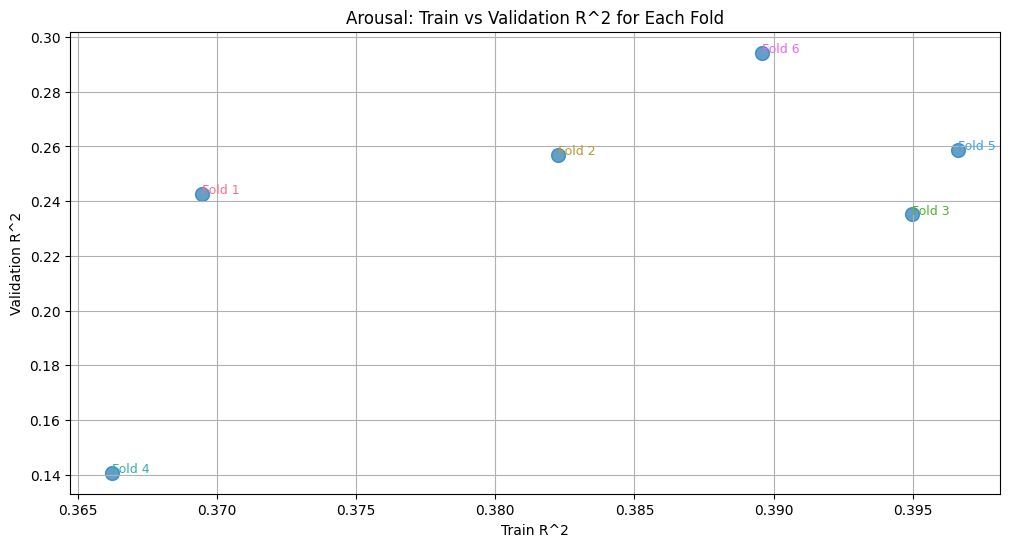

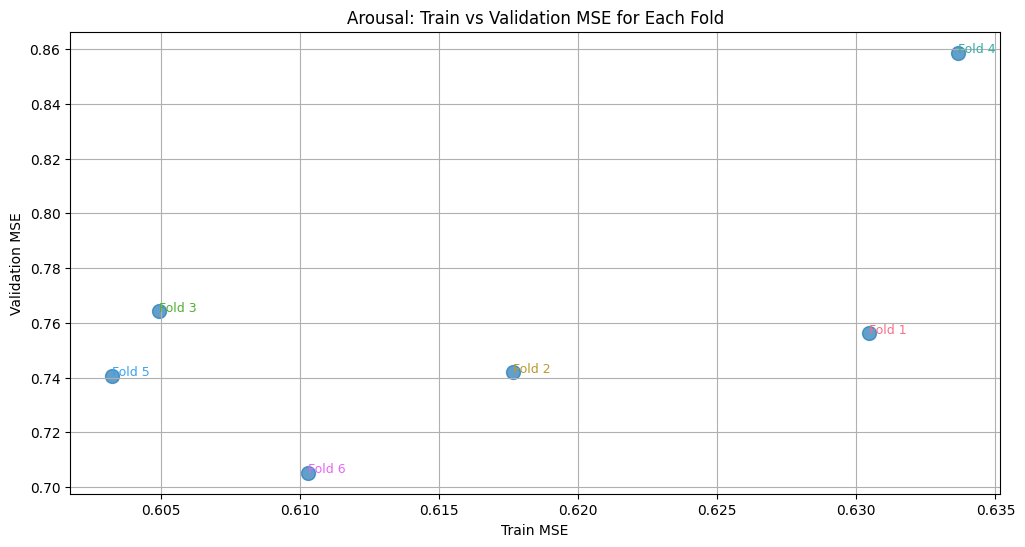

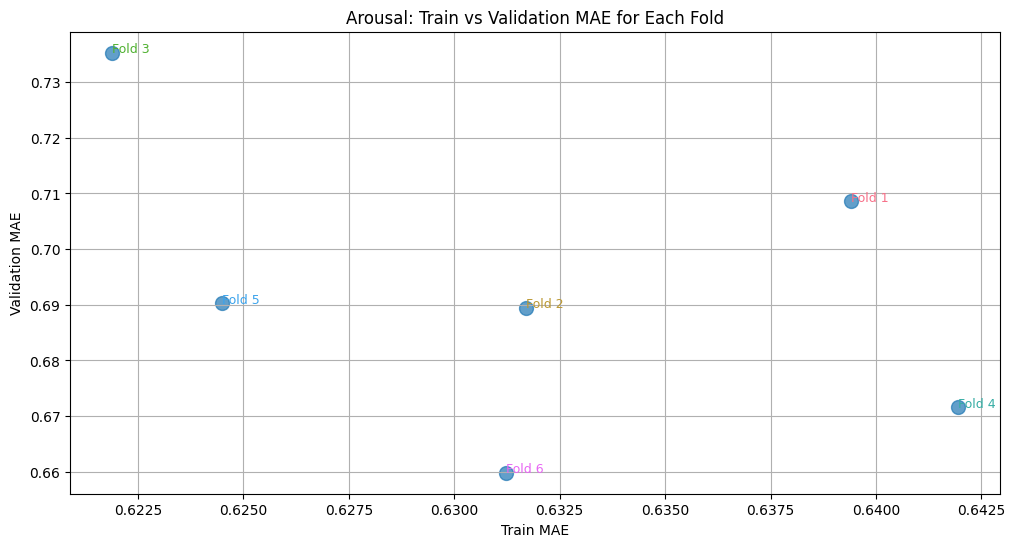

C:\Users\carme\AppData\Local\Temp\ipykernel_24292\1976227171.py:72: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  sns.heatmap(features_selected_df.applymap(lambda x: 1 if x == 'yes' else 0), cmap='YlGn', annot=True, fmt='d', cbar=False)


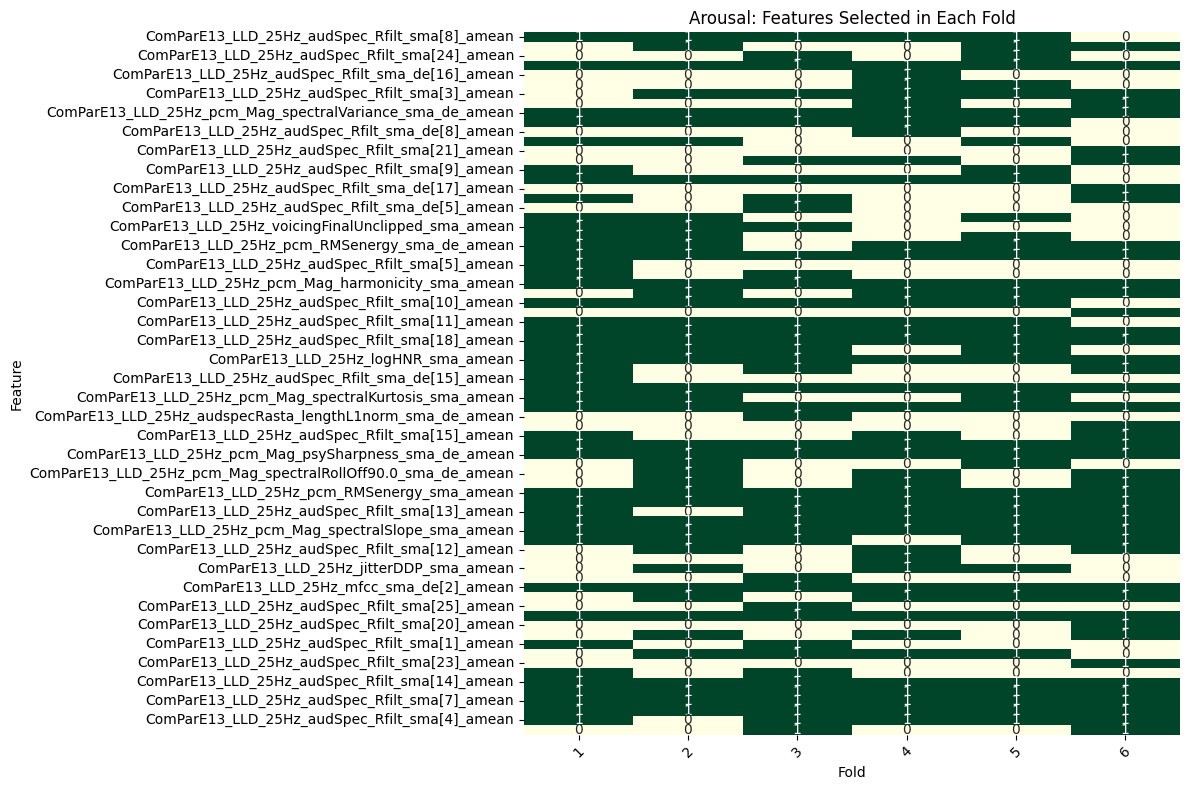

Results for Valence: 
Mean Train R^2: 0.1579, MSE: 0.8420, MAE: 0.7321
Mean Validation R^2: 0.0325, MSE: 0.9664, MAE: 0.7938


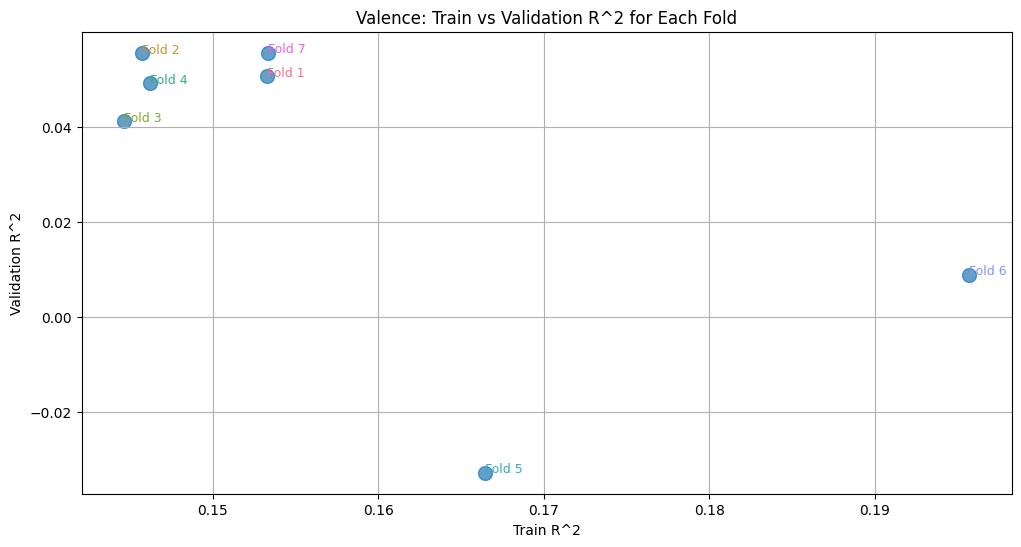

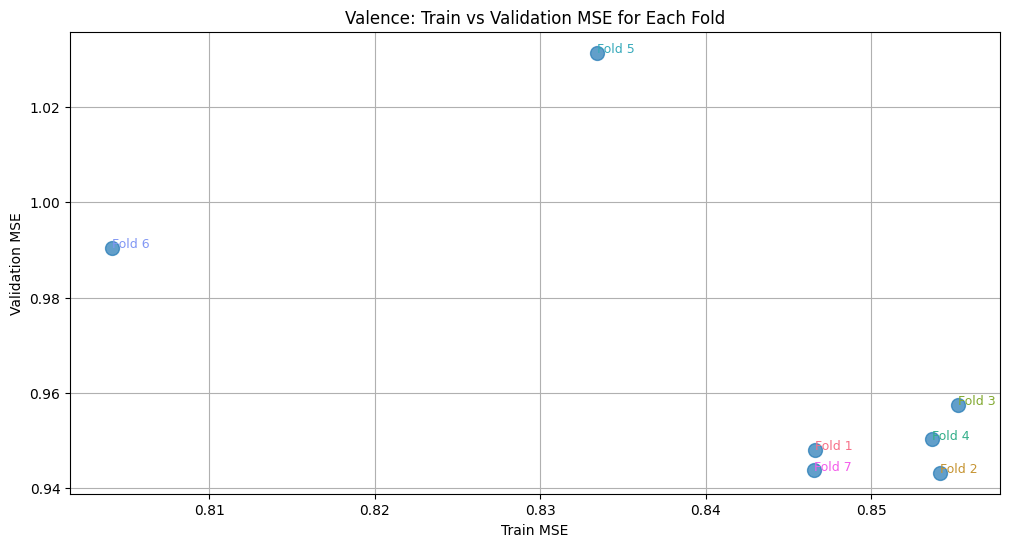

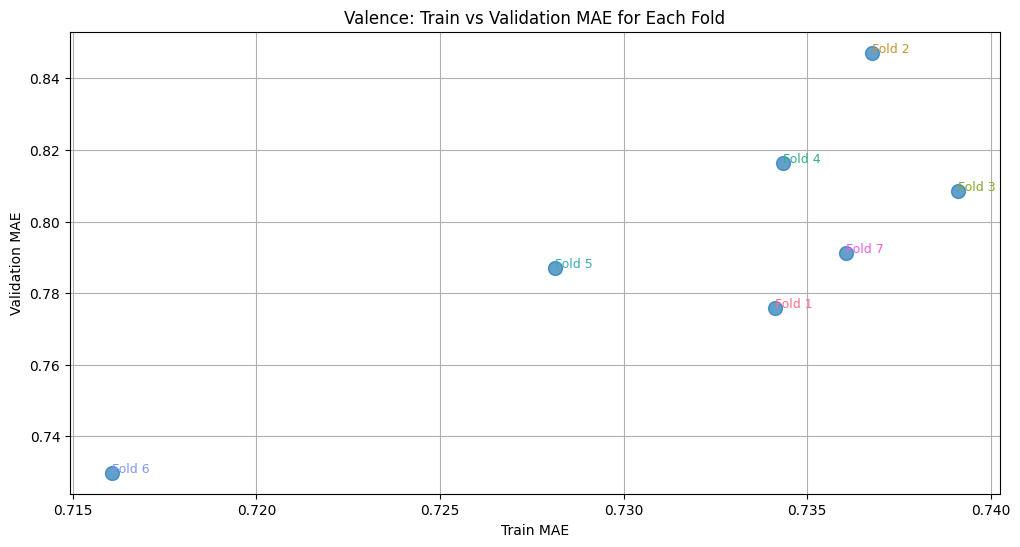

C:\Users\carme\AppData\Local\Temp\ipykernel_24292\1976227171.py:72: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  sns.heatmap(features_selected_df.applymap(lambda x: 1 if x == 'yes' else 0), cmap='YlGn', annot=True, fmt='d', cbar=False)


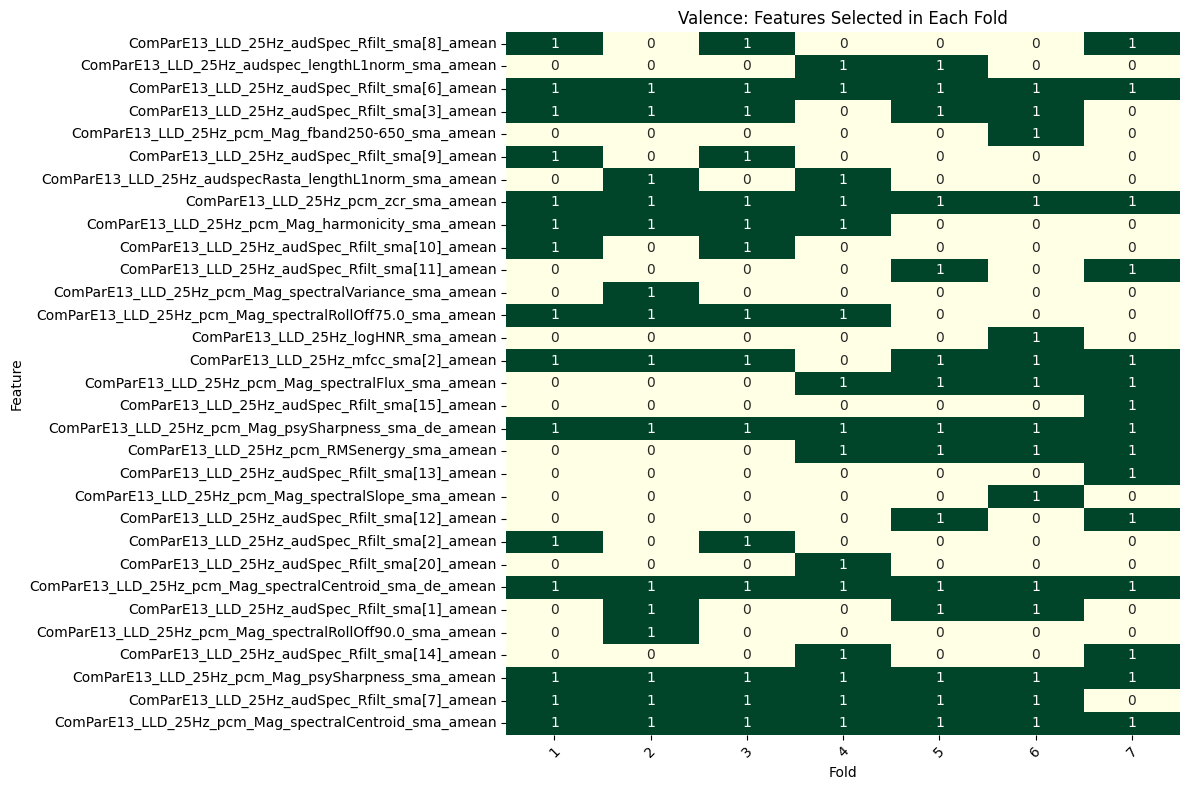

In [ ]:
import seaborn as sns

def analyze_cv_results(results_df, n_splits, title_prefix="", show_graphs=True):
    """
    Analyze cross-validation results: print mean metrics, plot train vs val metrics, 
    and show feature selection heatmap.
    """
    import matplotlib.pyplot as plt

    mean_train_r2 = results_df['Train R^2'].mean()
    mean_train_mse = results_df['Train MSE'].mean()
    mean_train_mae = results_df['Train MAE'].mean()

    mean_val_r2 = results_df['Val R^2'].mean()
    mean_val_mse = results_df['Val MSE'].mean()
    mean_val_mae = results_df['Val MAE'].mean()


    print(f"Results for {title_prefix}")
    print(f"Mean Train R^2: {mean_train_r2:.4f}, MSE: {mean_train_mse:.4f}, MAE: {mean_train_mae:.4f}")
    print(f"Mean Validation R^2: {mean_val_r2:.4f}, MSE: {mean_val_mse:.4f}, MAE: {mean_val_mae:.4f}")


    if show_graphs:
        colors = sns.color_palette("husl", n_splits)

        plt.figure(figsize=(12, 6))
        plt.scatter(results_df['Train R^2'], results_df['Val R^2'], alpha=0.7, s=100)
        plt.title(f'{title_prefix}Train vs Validation R^2 for Each Fold')
        plt.xlabel('Train R^2')
        plt.ylabel('Validation R^2')
        for i, row in results_df.iterrows():
            plt.annotate(f"Fold {row['Fold']}", (row['Train R^2'], row['Val R^2']), fontsize=9, color=colors[i % n_splits])
        plt.grid(True)
        plt.show()

        plt.figure(figsize=(12, 6))
        plt.scatter(results_df['Train MSE'], results_df['Val MSE'], alpha=0.7, s=100)
        plt.title(f'{title_prefix}Train vs Validation MSE for Each Fold')
        plt.xlabel('Train MSE')
        plt.ylabel('Validation MSE')
        for i, row in results_df.iterrows():
            plt.annotate(f"Fold {row['Fold']}", (row['Train MSE'], row['Val MSE']), fontsize=9, color=colors[i % n_splits])
        plt.grid(True)
        plt.show()

        plt.figure(figsize=(12, 6))
        plt.scatter(results_df['Train MAE'], results_df['Val MAE'], alpha=0.7, s=100)
        plt.title(f'{title_prefix}Train vs Validation MAE for Each Fold')
        plt.xlabel('Train MAE')
        plt.ylabel('Validation MAE')
        for i, row in results_df.iterrows():
            plt.annotate(f"Fold {row['Fold']}", (row['Train MAE'], row['Val MAE']), fontsize=9, color=colors[i % n_splits])
        plt.grid(True)
        plt.show()

        # Feature selection heatmap
        selected_features_set = set()
        for fold in range(n_splits):
            selected_features_set.update(results_df.loc[fold, 'Selected Features'])
        selected_features_set = list(selected_features_set)

        features_selected_df = pd.DataFrame(index=selected_features_set, columns=range(1, n_splits + 1))
        for fold in range(n_splits):
            selected_features = results_df.loc[fold, 'Selected Features']
            for feature in selected_features_set:
                features_selected_df.at[feature, fold + 1] = 'yes' if feature in selected_features else 'no'

        features_selected_df.to_csv(f"results/{title_prefix}features_selected.csv")

        plt.figure(figsize=(12, 8))
        sns.heatmap(features_selected_df.applymap(lambda x: 1 if x == 'yes' else 0), cmap='YlGn', annot=True, fmt='d', cbar=False)
        plt.title(f'{title_prefix}Features Selected in Each Fold')
        plt.xlabel('Fold')
        plt.ylabel('Feature')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

analyze_cv_results(results_arousal, NUMBER_OF_SPLITS_AROUSAL, title_prefix="Arousal: ", show_graphs=True)
analyze_cv_results(results_valence, NUMBER_OF_SPLITS_VALANCE, title_prefix="Valence: ", show_graphs=True)


<div class="alert alert-block alert-success">


## Evaluation Metrics

The model's performance was assessed using three key regression metrics: $R^2$, Mean Squared Error (MSE), and Mean Absolute Error (MAE). These were computed on both training and validation sets using GroupKFold cross-validation, ensuring validation always occurred on unseen participants. The results are reported separately for arousal and valence prediction.

### Arousal Prediction

**$R^2$**
- Training ($R^2 = 0.3832$) indicates moderate model fit to the training data, capturing around 38% of the variance in arousal scores. This suggests that the model learns meaningful structure while avoiding overfitting.
- Validation ($R^2 = 0.2381$) reflects relatively strong generalization performance given the difficulty of the task. A $R^2$ above 0.2 in cross-participant affect modeling is considered promising, especially for continuous regression on z-normalized arousal scores.
- The scatter plot of Train vs Validation $R^2$ shows most folds clustering tightly in the range 0.24–0.29, suggesting stable fold-wise generalization.

**Mean Squared Error (MSE)**
- Training MSE = 0.6167, Validation MSE = 0.7612
- The modest gap between training and validation MSEs shows controlled variance and no severe overfitting.
- Visualizations show folds distributed within a tight band, supporting model consistency.

**Mean Absolute Error (MAE)**
- Training MAE = 0.6318, Validation MAE = 0.6925
- With MAE under 0.7 (in z-normalized space), the model achieves reasonable average prediction error, further confirming generalizability.

#### Feature Selection Stability
The heatmap of selected features across folds shows many features were consistently selected, indicating that the model relies on a stable set of acoustic indicators to predict arousal.

#### Summary
The arousal model demonstrates generalization with a validation $R^2$ of 0.2381, outperforming earlier configurations. The small gap between training and validation metrics reflects a good balance between bias and variance. Feature selection was also stable, reinforcing the reliability of the input space.

### Valence Prediction

**$R^2$**
- Training ($R^2 = 0.1579$) shows that the model captures only a small amount of the variance in valence scores.
- Validation ($R^2 = 0.0325$) is marginally above zero, indicating near-baseline performance. Despite tuning, the model struggles to generalize to unseen participants for this variable.
- The validation $R^2$ plot shows tight clustering near zero across folds, confirming the absence of consistent predictive patterns.

**Mean Squared Error (MSE)**
- Training MSE = 0.8420, Validation MSE = 0.9664
- The larger gap compared to arousal suggests greater variance, possibly due to label noise or weaker correlation between acoustic features and valence.

**Mean Absolute Error (MAE)**
- Training MAE = 0.7321, Validation MAE = 0.7938
- While not disastrous, these values indicate that the model struggles to reliably predict valence across participants.

#### Feature Selection Stability
The valence heatmap shows high variability in selected features across folds, indicating low feature stability, consistent with poor predictive power.

#### Summary
Valence prediction remains a challenging task in this setup. The model shows weak generalization, with validation metrics near baseline. These results are consistent with known challenges in modeling valence acoustically, due to its subjective and ambiguous nature.

### Overall Observations
- Arousal prediction is meaningfully above baseline, with fold-stable metrics and stable features.
- Valence prediction performs near baseline with high variance and inconsistent feature selection.

---

### Additional references

- https://stackoverflow.com/questions/54859240/combination-of-all-parameters-for-grid-search
- https://www.nature.com/articles/s43856-024-00468-0

</div>

<div class="alert alert-block alert-success">

## Components sweep

Thhe following cells conduct a systematic exploration of the number of RFE features, PCA components, and Group K-old splits,  to assess their effect on the generalization performance of the arousal and valence regression models. The aim is to identify stable or optimal dimensionalities while holding all other model and feature selection parameters constant.

This process facilitates evidence-based tuning of hyperparameter and helps validate the choices made regarding dimensionality in the final model.

</div>

<div class="alert alert-block alert-success">

### RFE feature count sweep

</div>

Number of Features: 5
Number of Features: 10
Number of Features: 15
Number of Features: 20
Number of Features: 25
Number of Features: 30
Number of Features: 35
Number of Features: 40
Number of Features: 45


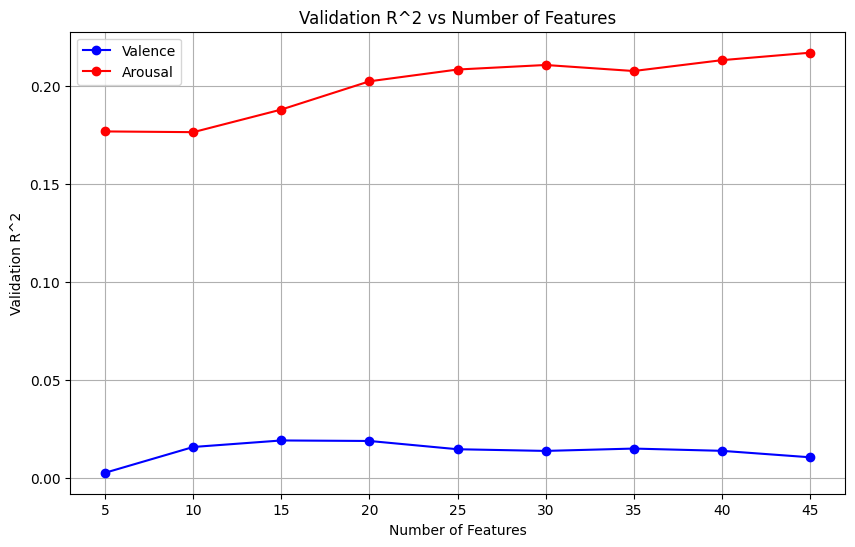

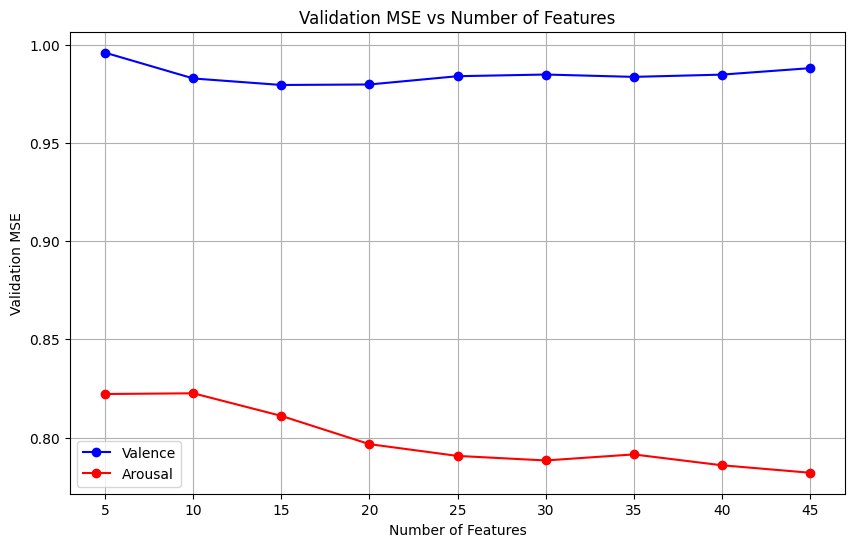

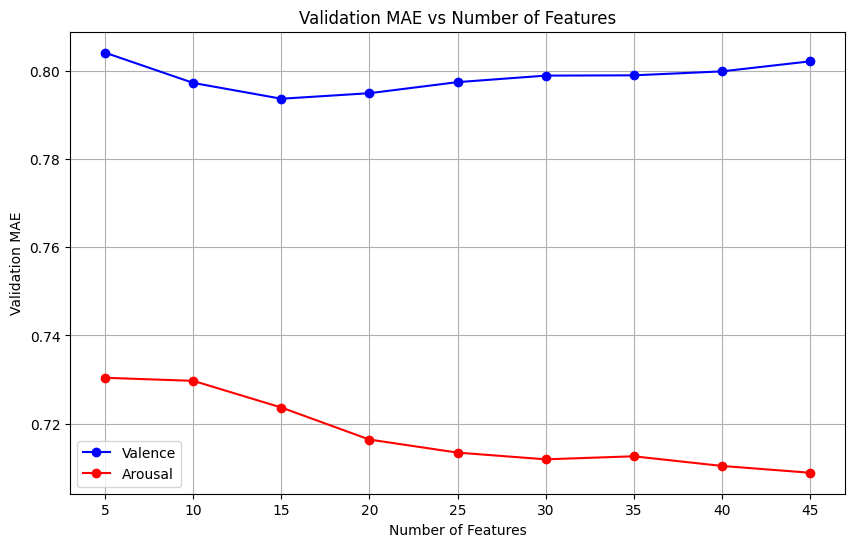

Best RFE Features for Valence: 15
Best RFE Features for Arousal: 45


In [ ]:
NUMBER_OF_SPLITS_AROUSAL = 10

param_arousal = {
    'n_estimators': 200,
    'max_depth': 5,
    'min_samples_split': 5,
    'min_samples_leaf': 1,
    'max_features': 'log2',
}
PCA_COMPONENTS_AROUSAL = 10


NUMBER_OF_SPLITS_VALANCE = 10

param_valence = {
    'n_estimators': 300,
    'max_depth': 5,
    'min_samples_split': 2,
    'min_samples_leaf': 5,
    'max_features': 'log2'
}
PCA_COMPONENTS_VALANCE = 10

r2s_valance_rfe = []
r2s_arousal_rfe = []
mses_valance_rfe = []
mses_arousal_rfe = []
maes_valance_rfe = []
maes_arousal_rfe = []

features_range = np.arange(5, 50, 5)

for features in features_range:

    print(f"Number of Features: {features}")

    results_valance_rfe = run_group_kfold_cv(X, y_median_valence, groups, splits=NUMBER_OF_SPLITS_VALANCE, rfe_features=features, pca_components=PCA_COMPONENTS_VALANCE, model_params=param_valence)
    r2s_valance_rfe.append(results_valance_rfe['Val R^2'].mean())
    mses_valance_rfe.append(results_valance_rfe['Val MSE'].mean())
    maes_valance_rfe.append(results_valance_rfe['Val MAE'].mean())

    results_arousal_rfe = run_group_kfold_cv(X, y_median_arousal, groups, splits=NUMBER_OF_SPLITS_AROUSAL, rfe_features=features, pca_components=PCA_COMPONENTS_AROUSAL, model_params=param_arousal)
    r2s_arousal_rfe.append(results_arousal_rfe['Val R^2'].mean())
    mses_arousal_rfe.append(results_arousal_rfe['Val MSE'].mean())
    maes_arousal_rfe.append(results_arousal_rfe['Val MAE'].mean())

plt.figure(figsize=(10, 6))
plt.plot(features_range, r2s_valance_rfe, marker='o', linestyle='-', color='b', label='Valence')
plt.plot(features_range, r2s_arousal_rfe, marker='o', linestyle='-', color='r', label='Arousal')
plt.xlabel('Number of Features')
plt.ylabel('Validation R^2')
plt.title('Validation R^2 vs Number of Features')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(features_range, mses_valance_rfe, marker='o', linestyle='-', color='b', label='Valence')
plt.plot(features_range, mses_arousal_rfe, marker='o', linestyle='-', color='r', label='Arousal')
plt.xlabel('Number of Features')
plt.ylabel('Validation MSE')
plt.title('Validation MSE vs Number of Features')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(features_range, maes_valance_rfe, marker='o', linestyle='-', color='b', label='Valence')
plt.plot(features_range, maes_arousal_rfe, marker='o', linestyle='-', color='r', label='Arousal')
plt.xlabel('Number of Features')
plt.ylabel('Validation MAE')
plt.title('Validation MAE vs Number of Features')
plt.legend()
plt.grid(True)
plt.show()

print(f"Best RFE Features for Valence: {features_range[r2s_valance_rfe.index(max(r2s_valance_rfe))]}")
print(f"Best RFE Features for Arousal: {features_range[r2s_arousal_rfe.index(max(r2s_arousal_rfe))]}")

<div class="alert alert-block alert-success">

### PCA components sweep

</div>

PCA Components: 5
PCA Components: 10
PCA Components: 15
PCA Components: 20
PCA Components: 25
PCA Components: 30
PCA Components: 35
PCA Components: 40


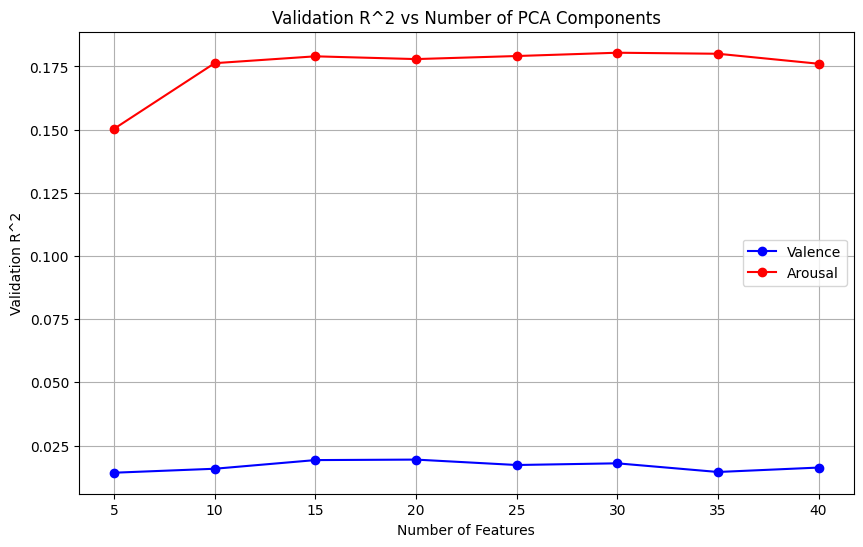

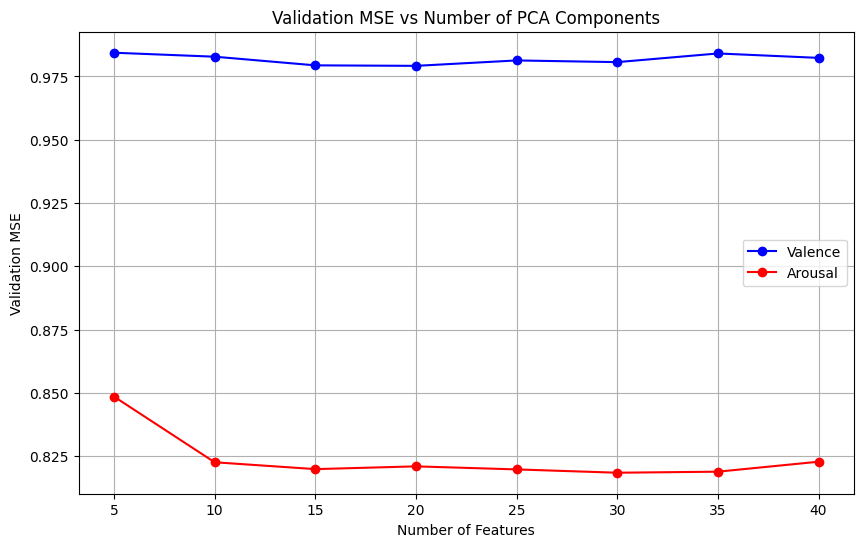

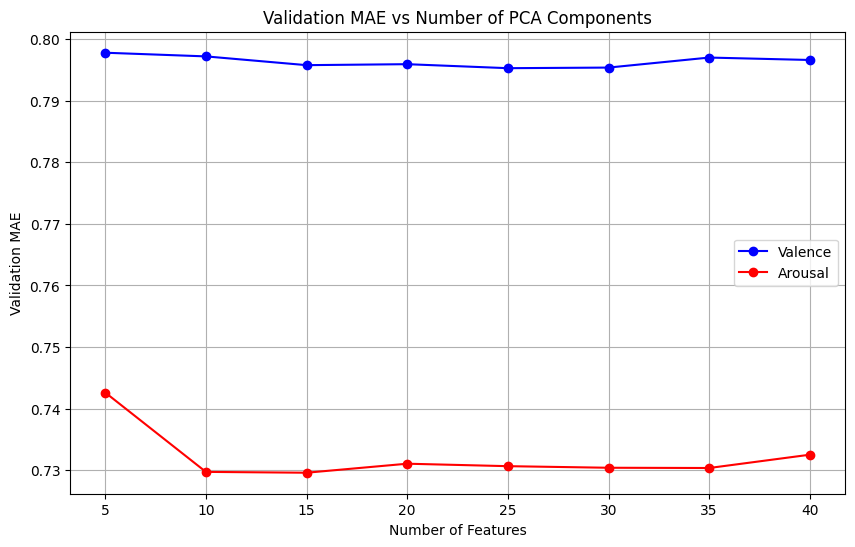

Best PCA Components for Valence: 20
Best PCA Components for Arousal: 30


In [177]:
NUMBER_OF_SPLITS_AROUSAL = 10
NUMBER_OF_RFE_FEATURES_AROUSAL = 15
param_arousal = {
    'n_estimators': 200,
    'max_depth': 5,
    'min_samples_split': 5,
    'min_samples_leaf': 1,
    'max_features': 'log2',
}

NUMBER_OF_SPLITS_VALANCE = 10
NUMBER_OF_RFE_FEATURES_VALENCE = 45
param_valence = {
    'n_estimators': 300,
    'max_depth': 5,
    'min_samples_split': 2,
    'min_samples_leaf': 5,
    'max_features': 'log2'
}

r2s_valance_pca = []
r2s_arousal_pca = []
mses_valance_pca = []
mses_arousal_pca = []
maes_valance_pca = []
maes_arousal_pca = []

pca_components_range = np.arange(5, 15, 5)

for pca_components in pca_components_range:
    
    print(f"PCA Components: {pca_components}")
        
    results_valance_pca = run_group_kfold_cv(X, y_median_valence, groups, splits=NUMBER_OF_SPLITS_VALANCE, rfe_features=NUMBER_OF_RFE_FEATURES_VALENCE, pca_components=pca_components, model_params=param_valence)
    r2s_valance_pca.append(results_valance_pca['Val R^2'].mean())
    mses_valance_pca.append(results_valance_pca['Val MSE'].mean())
    maes_valance_pca.append(results_valance_pca['Val MAE'].mean())

    results_arousal_rfe = run_group_kfold_cv(X, y_median_arousal, groups, splits=NUMBER_OF_SPLITS_AROUSAL, rfe_features=NUMBER_OF_RFE_FEATURES_AROUSAL, pca_components=pca_components, model_params=param_arousal)
    r2s_arousal_pca.append(results_arousal_rfe['Val R^2'].mean())
    mses_arousal_pca.append(results_arousal_rfe['Val MSE'].mean())
    maes_arousal_pca.append(results_arousal_rfe['Val MAE'].mean())

plt.figure(figsize=(10, 6))
plt.plot(pca_components_range, r2s_valance_pca, marker='o', linestyle='-', color='b', label='Valence')
plt.plot(pca_components_range, r2s_arousal_pca, marker='o', linestyle='-', color='r', label='Arousal')
plt.xlabel('Number of Features')
plt.ylabel('Validation R^2')
plt.title('Validation R^2 vs Number of PCA Components')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(pca_components_range, mses_valance_pca, marker='o', linestyle='-', color='b', label='Valence')
plt.plot(pca_components_range, mses_arousal_pca, marker='o', linestyle='-', color='r', label='Arousal')
plt.xlabel('Number of Features')
plt.ylabel('Validation MSE')
plt.title('Validation MSE vs Number of PCA Components')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(pca_components_range, maes_valance_pca, marker='o', linestyle='-', color='b', label='Valence')
plt.plot(pca_components_range, maes_arousal_pca, marker='o', linestyle='-', color='r', label='Arousal')
plt.xlabel('Number of Features')
plt.ylabel('Validation MAE')
plt.title('Validation MAE vs Number of PCA Components')
plt.legend()
plt.grid(True)
plt.show()

print(f"Best PCA Components for Valence: {pca_components_range[r2s_valance_pca.index(max(r2s_valance_pca))]}")
print(f"Best PCA Components for Arousal: {pca_components_range[r2s_arousal_pca.index(max(r2s_arousal_pca))]}")


<div class="alert alert-block alert-success">

### Splits sweep

</div>

Number of Splits: 5
Number of Splits: 6
Number of Splits: 7
Number of Splits: 8
Number of Splits: 9
Number of Splits: 10


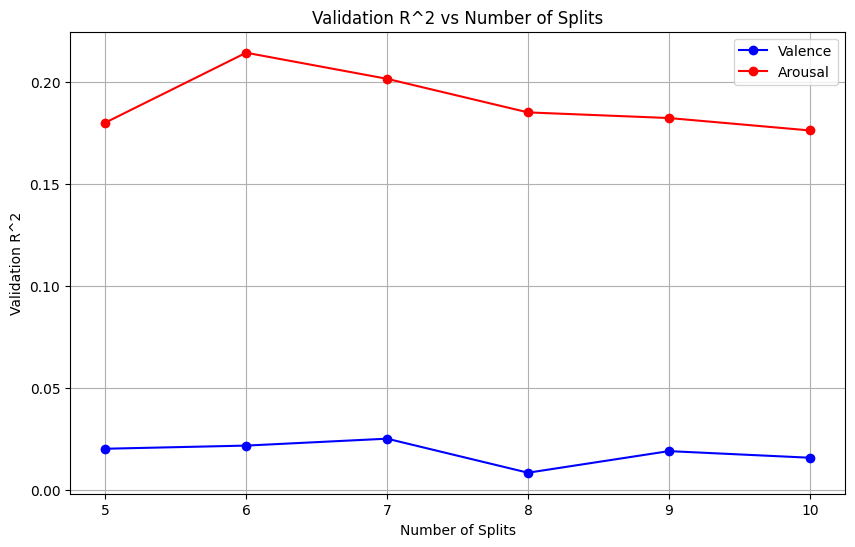

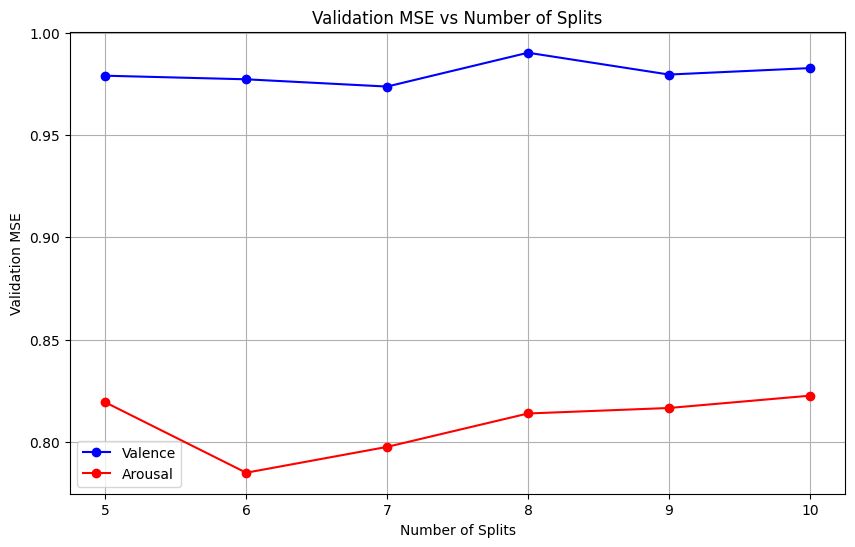

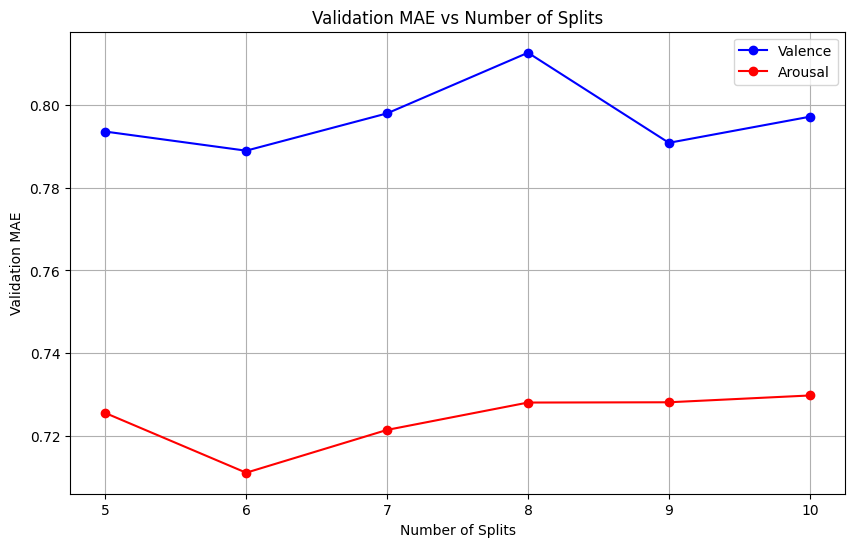

Best Splits for Valence: 7
Best Splits for Arousal: 6


In [179]:

NUMBER_OF_RFE_FEATURES_AROUSAL = 10
param_arousal = {
    'n_estimators': 200,
    'max_depth': 5,
    'min_samples_split': 5,
    'min_samples_leaf': 1,
    'max_features': 'log2',
}
PCA_COMPONENTS_AROUSAL = 10


NUMBER_OF_RFE_FEATURES_VALENCE = 10
param_valence = {
    'n_estimators': 300,
    'max_depth': 5,
    'min_samples_split': 2,
    'min_samples_leaf': 5,
    'max_features': 'log2'
}
PCA_COMPONENTS_VALANCE = 10

r2s_valance_splits = []
r2s_arousal_splits = []
mses_valance_splits = []
mses_arousal_splits = []
maes_valance_splits = []
maes_arousal_splits = []

splits_range = np.arange(5, 11, 1)

for splits in splits_range:

    print(f"Number of Splits: {splits}")

    results_valance_splits = run_group_kfold_cv(X, y_median_valence, groups, splits=splits, rfe_features=NUMBER_OF_RFE_FEATURES_VALENCE, pca_components=PCA_COMPONENTS_VALANCE, model_params=param_valence)
    r2s_valance_splits.append(results_valance_splits['Val R^2'].mean())
    mses_valance_splits.append(results_valance_splits['Val MSE'].mean())
    maes_valance_splits.append(results_valance_splits['Val MAE'].mean())
    
    results_arousal_splits = run_group_kfold_cv(X, y_median_arousal, groups, splits=splits, rfe_features=NUMBER_OF_RFE_FEATURES_AROUSAL, pca_components=PCA_COMPONENTS_AROUSAL, model_params=param_arousal)
    r2s_arousal_splits.append(results_arousal_splits['Val R^2'].mean())
    mses_arousal_splits.append(results_arousal_splits['Val MSE'].mean())
    maes_arousal_splits.append(results_arousal_splits['Val MAE'].mean())

plt.figure(figsize=(10, 6))
plt.plot(splits_range, r2s_valance_splits, marker='o', linestyle='-', color='b', label='Valence')
plt.plot(splits_range, r2s_arousal_splits, marker='o', linestyle='-', color='r', label='Arousal')
plt.xlabel('Number of Splits')
plt.ylabel('Validation R^2')
plt.title('Validation R^2 vs Number of Splits')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(splits_range, mses_valance_splits, marker='o', linestyle='-', color='b', label='Valence')
plt.plot(splits_range, mses_arousal_splits, marker='o', linestyle='-', color='r', label='Arousal')
plt.xlabel('Number of Splits')
plt.ylabel('Validation MSE')
plt.title('Validation MSE vs Number of Splits')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(splits_range, maes_valance_splits, marker='o', linestyle='-', color='b', label='Valence')
plt.plot(splits_range, maes_arousal_splits, marker='o', linestyle='-', color='r', label='Arousal')
plt.xlabel('Number of Splits')
plt.ylabel('Validation MAE')
plt.title('Validation MAE vs Number of Splits')
plt.legend()
plt.grid(True)
plt.show()

print(f"Best Splits for Valence: {splits_range[r2s_valance_splits.index(max(r2s_valance_splits))]}")
print(f"Best Splits for Arousal: {splits_range[r2s_arousal_splits.index(max(r2s_arousal_splits))]}")



## Step 2: Hyperparameter optimization

In [108]:

# from itertools import product
# import time
# ## arousal hyperparameter tuning

# start_time = time.time()


# df_arousal_hyperparameter_results = pd.DataFrame(columns=['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'max_features', 'Train R^2', 'Val R^2'])

# n_estimators = [50, 100, 200]
# max_depth = [None, 10, 20]
# min_samples_split = [2, 5]
# min_samples_leaf = [1, 2]
# max_features = [None, 'sqrt', 'log2']

# param_combinations = product(n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features)
# param_list = list(param_combinations)
# n_combinations = len(param_list)
# count_combinations = 0

# print(f"Total hyperparameter combinations to test: {n_combinations}")

# print(len(param_list))

# for param in param_list:

#     count_combinations += 1
#     print(f"Processing hyperparameter combination {count_combinations} of {n_combinations}: {param}")
    
#     param = {
#         'n_estimators': param[0],
#         'max_depth': param[1],
#         'min_samples_split': param[2],
#         'min_samples_leaf': param[3],
#         'max_features': param[4]
#     }
    
#     results_file_name = f"results/hyperparam/arousal_hyperparameter_results_{param['n_estimators']}_{param['max_depth']}_{param['min_samples_split']}_{param['min_samples_leaf']}_{param['max_features']}.csv"
    
#     results = run_group_kfold_cv(X, y_median_arousal, groups, splits=NUMBER_OF_SPLITS, rfe_features=NUMBER_OF_RFE_FEATURES_AROUSAL, results_path=results_file_name, model_params=param)
#     mean_train_r2 = results['Train R^2'].mean()
#     mean_val_r2 = results['Val R^2'].mean()
    
#     results_dict = {
#         'n_estimators': param['n_estimators'],
#         'max_depth': param['max_depth'],
#         'min_samples_split': param['min_samples_split'],
#         'min_samples_leaf': param['min_samples_leaf'],
#         'max_features': param['max_features'],
#         'Train R^2': mean_train_r2,
#         'Val R^2': mean_val_r2
#     }
    
#     if count_combinations == 1:
#         df_arousal_hyperparameter_results = pd.DataFrame([results_dict])
#     else:
#         df_arousal_hyperparameter_results = pd.concat([df_arousal_hyperparameter_results, pd.DataFrame([results_dict])], ignore_index=True)

# df_arousal_hyperparameter_results.to_csv("results/arousal_hyperparameter_results.csv", index=False)

# end_time_arousal = time.time()


# ## valence hyperparameter tuning

# df_valence_hyperparameter_results = pd.DataFrame(columns=['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'max_features', 'Train R^2', 'Val R^2'])

# n_estimators = [100, 200, 300]
# max_depth = [None, 10, 20]
# min_samples_split = [2, 5, 10]
# min_samples_leaf = [1, 3, 5]
# max_features = ['sqrt', 'log2']

# param_combinations = product(n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features)
# param_list = list(param_combinations)
# n_combinations = len(param_list)
# count_combinations = 0

# for param in param_list:

#     count_combinations += 1
#     print(f"Processing hyperparameter combination {count_combinations} of {n_combinations}: {param}")
    
#     param = {
#         'n_estimators': param[0],
#         'max_depth': param[1],
#         'min_samples_split': param[2],
#         'min_samples_leaf': param[3],
#         'max_features': param[4]
#     }
    
#     results_file_name = f"results/hyperparam/valence_hyperparameter_results_{param['n_estimators']}_{param['max_depth']}_{param['min_samples_split']}_{param['min_samples_leaf']}_{param['max_features']}.csv"
    
#     results = run_group_kfold_cv(X, y_median_valence, groups, splits=NUMBER_OF_SPLITS, rfe_features=NUMBER_OF_RFE_FEATURES_VALENCE, results_path=results_file_name, model_params=param)
#     mean_train_r2 = results['Train R^2'].mean()
#     mean_val_r2 = results['Val R^2'].mean()
    
#     results_dict = {
#         'n_estimators': param['n_estimators'],
#         'max_depth': param['max_depth'],
#         'min_samples_split': param['min_samples_split'],
#         'min_samples_leaf': param['min_samples_leaf'],
#         'max_features': param['max_features'],
#         'Train R^2': mean_train_r2,
#         'Val R^2': mean_val_r2
#     }
    
#     if count_combinations == 1:
#         df_valence_hyperparameter_results = pd.DataFrame([results_dict])
#     else:
#         df_valence_hyperparameter_results = pd.concat([df_valence_hyperparameter_results, pd.DataFrame([results_dict])], ignore_index=True)
    
# df_valence_hyperparameter_results.to_csv("results/valence_hyperparameter_results.csv", index=False)

# end_time_valence = time.time()

# print(f"Total time for arousal hyperparameter tuning: {end_time_arousal - start_time:.2f} seconds")
# print(f"Total time for valence hyperparameter tuning: {end_time_valence - end_time_arousal:.2f} seconds")
    

In [109]:
df_hyperpar_res_arousal = pd.read_csv("results/arousal_hyperparameter_results.csv")
min_r_squared_rows = df_hyperpar_res_arousal.nlargest(6, 'Val R^2')
print("Rows with Largest R^2:")
print(min_r_squared_rows)


df_hyperpar_res_valence = pd.read_csv("results/valence_hyperparameter_results.csv")
min_r_squared_rows = df_hyperpar_res_valence.nlargest(6, 'Val R^2')
print("Rows with Largest R^2:")
print(min_r_squared_rows)


Rows with Largest R^2:
    n_estimators  max_depth  min_samples_split  min_samples_leaf max_features  \
91           200       10.0                  5                 1         sqrt   
92           200       10.0                  5                 1         log2   
55           100       10.0                  5                 1         sqrt   
56           100       10.0                  5                 1         log2   
19            50       10.0                  5                 1         sqrt   
20            50       10.0                  5                 1         log2   

    Train R^2   Val R^2  
91   0.543349  0.169199  
92   0.543349  0.169199  
55   0.542046  0.168517  
56   0.542046  0.168517  
19   0.540806  0.166304  
20   0.540806  0.166304  
Rows with Largest R^2:
     n_estimators  max_depth  min_samples_split  min_samples_leaf  \
130           300       10.0                  2                 5   
131           300       10.0                  2                 5 

<div class="alert alert-block alert-success">

## Final model preparation

</div>

In [201]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.decomposition import PCA
from scipy.stats import zscore

def run_final_model(df_raw, target_col='median_valence', rfe_features=30, pca_components=10, model_params=None):
    
    # outlier removal
    df_clean = df_raw.copy()
    z_thresh = 3
    df_clean['z_arousal'] = zscore(df_clean['median_arousal'])
    df_clean['z_valence'] = zscore(df_clean['median_valence'])
    df_clean = df_clean[
        (df_clean['z_arousal'].abs() <= z_thresh) &
        (df_clean['z_valence'].abs() <= z_thresh)
    ]

    df_clean = df_clean.drop(columns=['z_arousal', 'z_valence'])

    print(f"Original dataset shape: {df_raw.shape}")
    print(f"Cleaned dataset shape: {df_clean.shape}")

    # Normalized target
    y = (df_clean[target_col] - df_clean[target_col].mean()) / df_clean[target_col].std()
    X = df_clean.drop(columns=['Participant', 'median_arousal', 'median_valence'])

    print(X.shape)

    # scale features for rfe as it uses         
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

    estimator = LinearRegression()
    rfe_selector = RFE(estimator=estimator, n_features_to_select=rfe_features, step=1)
    rfe_selector.fit(X_scaled, y)
    selected_features_mask = rfe_selector.support_
    current_selected_features = X_scaled.columns[selected_features_mask].tolist()

    X_selected = X[current_selected_features]


    if pd.isnull(X_scaled).any().any():
        raise ValueError("X_scaled contains NaN values, which PCA cannot handle.")

    #pca
    pca = PCA(n_components=pca_components)
    X_pca = pca.fit_transform(X_selected)
    
    print(X_pca.shape, X_selected.shape)
    
    X_selected = np.concatenate([X_selected, X_pca], axis=1)

    # Model configuration
    if model_params is None:
        model_params = {
            'n_estimators': 100,
            'max_depth': None,
            'min_samples_split': 2,
            'min_samples_leaf': 1,
            'max_features': None
        }

    n_estimators = model_params['n_estimators']
    max_depth = model_params['max_depth']
    min_samples_split = model_params['min_samples_split']
    min_samples_leaf = model_params['min_samples_leaf']
    max_features = model_params['max_features']

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42)
    model.fit(X_selected, y)

    y_pred = model.predict(X_selected)
    r2 = r2_score(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)

    print(f"Final Model Evaluation for {target_col}:")
    print(f"R^2: {r2:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    

run_final_model(
    df_raw,
    target_col='median_arousal',
    pca_components=30,
    rfe_features=45,
    model_params={
        'n_estimators': 200,
        'max_depth': 5,
        'min_samples_split': 5,
        'min_samples_leaf': 3,
        'max_features': 'log2'
    }
)

run_final_model(
    df_raw,
    target_col='median_valence',
    pca_components=10,
    rfe_features=15,
    model_params={
        'n_estimators': 200,
        'max_depth': 5,
        'min_samples_split': 2,
        'min_samples_leaf': 5,
        'max_features': 'log2'
    }
)


Original dataset shape: (7238, 133)
Cleaned dataset shape: (7216, 133)
(7216, 130)
(7216, 30) (7216, 45)
Final Model Evaluation for median_arousal:
R^2: 0.3733
MSE: 0.6266
MAE: 0.6375
Original dataset shape: (7238, 133)
Cleaned dataset shape: (7216, 133)
(7216, 130)
(7216, 10) (7216, 15)
Final Model Evaluation for median_valence:
R^2: 0.1738
MSE: 0.8261
MAE: 0.7216


<div class="alert alert-block alert-info">

### A common approach in affect modelling is arousal/valence binarization. Towards this direction, a threshold value is defined and emotional states with arousal/valence values larger than or equal to that threshold are denoted as “high” arousal/valence, while emotional states with arousal/valence value lower than the threshold are denoted as “low” arousal/valence.

#### Select and justify appropriate threshold values for binarizing both arousal and valence annotations (the threshold for binarizing arousal should not necessarily be equal to the threshold for binarizing valence).
</div>

<div class="alert alert-block alert-success">

## Threshold Determination

Let us start this discussion by looking at the median values of arousal and valence

</div>

Original dataset shape: (7238, 133)
Cleaned dataset shape: (7216, 133)


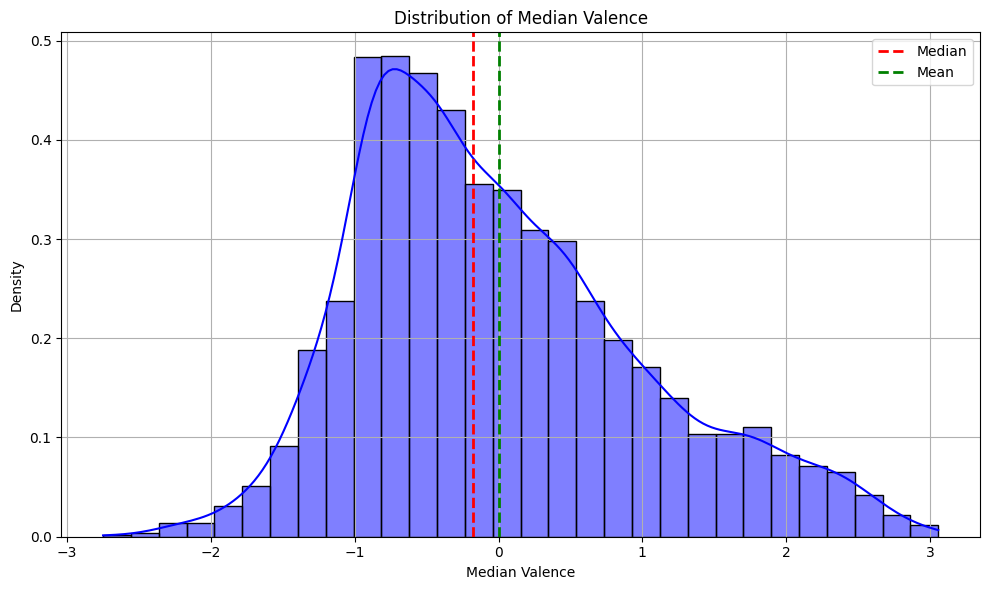

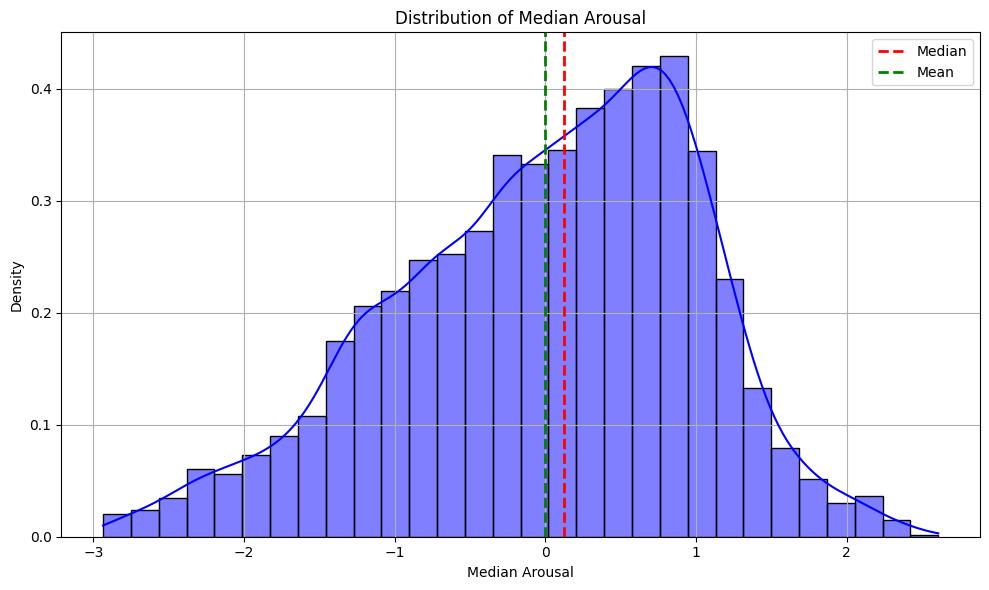

 for median_valence: median=-0.1804, mean=-0.0000
 for median_arousal: median=0.1271, mean=0.0000


In [324]:
df_binary_raw = df_raw.copy()

print(f"Original dataset shape: {df_binary_raw.shape}")
# remove the oputliers
z_thresh = 3
df_binary_raw['z_arousal'] = zscore(df_binary_raw['median_arousal'])
df_binary_raw['z_valence'] = zscore(df_binary_raw['median_valence'])
df_binary_clean = df_binary_raw[
    (df_binary_raw['z_arousal'].abs() <= z_thresh) &
    (df_binary_raw['z_valence'].abs() <= z_thresh)
]

df_binary_clean = df_binary_clean.drop(columns=['z_arousal', 'z_valence'])

print(f"Cleaned dataset shape: {df_binary_clean.shape}")


# norm, z
median_valance_mean = df_binary_clean['median_valence'].mean()
median_valance_std = df_binary_clean['median_valence'].std()
median_arousal_mean = df_binary_clean['median_arousal'].mean()
median_arousal_std = df_binary_clean['median_arousal'].std()

df_binary_clean['median_valence'] = (df_binary_clean['median_valence'] - median_valance_mean) / median_valance_std
df_binary_clean['median_arousal'] = (df_binary_clean['median_arousal'] - median_arousal_mean) / median_arousal_std

median_valance_median = df_binary_clean['median_valence'].median()
median_valance_mean = df_binary_clean['median_valence'].mean()
median_valance_std = df_binary_clean['median_valence'].std()

median_arousal_median = df_binary_clean['median_arousal'].median()
median_arousal_mean = df_binary_clean['median_arousal'].mean()
median_arousal_std = df_binary_clean['median_arousal'].std()

#check
# print(f"Median Valence: {median_valance_median}")
# print(f"Mean Valence: {median_valance_mean}")
# print(f"Standard Deviation Valence: {median_valance_std}")
# print(f"Median Arousal: {median_arousal_median}")
# print(f"Mean Arousal: {median_arousal_mean}")
# print(f"Standard Deviation Arousal: {median_arousal_std}")

plt.figure(figsize=(10, 6))
sns.histplot(df_binary_clean['median_valence'], bins=30, kde=True, color='blue', stat='density')
plt.xlabel('Median Valence')
plt.ylabel('Density')
plt.title('Distribution of Median Valence')
plt.axvline(median_valance_median, color='red', linestyle='dashed', linewidth=2, label='Median')
plt.axvline(median_valance_mean, color='green', linestyle='dashed', linewidth=2, label='Mean')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# median_arousal distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_binary_clean['median_arousal'], bins=30, kde=True, color='blue', stat='density')
plt.xlabel('Median Arousal')
plt.ylabel('Density')
plt.title('Distribution of Median Arousal')
plt.axvline(median_arousal_median, color='red', linestyle='dashed', linewidth=2, label='Median')
plt.axvline(median_arousal_mean, color='green', linestyle='dashed', linewidth=2, label='Mean')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f" for median_valence: median={median_valance_median:.4f}, mean={median_valance_mean:.4f}")
print(f" for median_arousal: median={median_arousal_median:.4f}, mean={median_arousal_mean:.4f}")


<div class="alert alert-block alert-success">


To ensure robustness, threshold determination was computed after removing anomalies across the dataset.

After standardizing the distributions, the statistical properties of `median_valence` and `median_arousal` are analyzed.

For `median_valence`, the distribution has noticeable right-skewed, with a peak just below zero and a long tail extending toward higher values. The mean is positioned to the right of the median, reflecting this skew. Choosing the median (−0.1804) as the threshold ensures a more balanced binarization between the "low" and "high" valence classes.

For median_arousal, the distribution is more symmetric but still slightly skewed right. The median (0.1271) and mean are closer than the valance case, indicating a closer-to-normal distribution. In this case, it is interesting to use either the mean or median for thresholding, though again, the median offers a statistically robust and balance-preserving option.

In summary, both thresholds should ideally be based on the medians of the respective distributions, especially for valence, where the skew is more prominent, ensuring an equitable split between the binary categories. 

</div>

In [325]:
valance_threshold = median_valance_median
arousal_threshold = median_arousal_median

df_binary_clean['valence_binary'] = np.where(df_binary_clean['median_valence'] >= valance_threshold, 1, 0)
df_binary_clean['arousal_binary'] = np.where(df_binary_clean['median_arousal'] >= arousal_threshold, 1, 0)

# check
valence_ones = df_binary_clean['valence_binary'].sum()
print(f"Number of ones in valence_binary: {valence_ones} of {len(df_binary_clean)}")

# check
arousal_ones = df_binary_clean['arousal_binary'].sum()
print(f"Number of ones in arousal_binary: {arousal_ones} of {len(df_binary_clean)}")


Number of ones in valence_binary: 3610 of 7216
Number of ones in arousal_binary: 3608 of 7216


<div class="alert alert-block alert-info">

#### Implement a predictive model for each binarized response variable.
#### Select appropriate metrics to evaluate the performance of the model in this scenario using the validation protocol you proposed in Task 1.

</div>

In [365]:
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve



In [347]:
X_binary = df_binary_clean.drop(columns=['Participant', 'median_arousal', 'median_valence', 'valence_binary', 'arousal_binary'])
y_arousal_binary = df_binary_clean['arousal_binary']
y_valence_binary = df_binary_clean['valence_binary']
groups_binary = df_binary_clean['Participant']


In [362]:
def run_binary_classification(X, y, groups, rfe_features=10, splits=10, results_path="binary_results.csv", model_params=None):

    results_df = pd.DataFrame(columns=[
        "Fold", "F1", "Accuracy", 'Precision', 'Recall', "True Negative", "False Positive", "False Negative", "True Positive"
    ])

    sgkf = StratifiedGroupKFold(n_splits=splits, shuffle=True, random_state=42)

    y_val_all = []
    y_pred_all = []
    y_proba_all = []

    fold = 1
    for train_idx, val_idx in sgkf.split(X, y, groups):
        # print(f"Fold {fold}:")

        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
        # RFE
        rfe_estimator = LogisticRegression(solver='liblinear', max_iter=1000)
        rfe = RFE(estimator=rfe_estimator, n_features_to_select=rfe_features)
        rfe.fit(X_train, y_train)
        selected_features = X_train.columns[rfe.support_]
        X_train_selected = X_train[selected_features]
        X_val_selected = X_val[selected_features]

        
        model = LogisticRegression(solver='liblinear', max_iter=1000,  penalty='l1', class_weight='balanced')
        # random_forest = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
                
        # model = VotingClassifier(
        # estimators=[
        #         ('lr', logistic),
        #         ('rf', random_forest)
        #     ],
        #     voting='hard'  # majority class
        # )


        model.fit(X_train_selected, y_train)
        # Predict
        y_pred = model.predict(X_val_selected)
        y_proba = model.predict_proba(X_val_selected)
        
        y_val_all.append(y_val)
        y_pred_all.append(y_pred)
        y_proba_all.append(y_proba)
        

        f1 = f1_score(y_val, y_pred)
        acc = accuracy_score(y_val, y_pred)
        cm = confusion_matrix(y_val, y_pred)
        precision = precision_score(y_val, y_pred)
        recall = recall_score(y_val, y_pred)

        results_line = {
            "Fold": fold,
            "F1": f1,
            "Accuracy": acc,
            "Precision": precision,
            "Recall": recall,
            "True Negative": cm[0, 0],
            "False Positive": cm[0, 1],
            "False Negative": cm[1, 0],
            "True Positive": cm[1, 1],
        }

        if fold == 1:
            results_df = pd.DataFrame([results_line])
        else:
            results_df = pd.concat([results_df, pd.DataFrame([results_line])], ignore_index=True)

        fold += 1

    # save the results dataframe in a file
    results_df.to_csv(results_path, index=False)
    return results_df, y_val_all, y_pred_all, y_proba_all


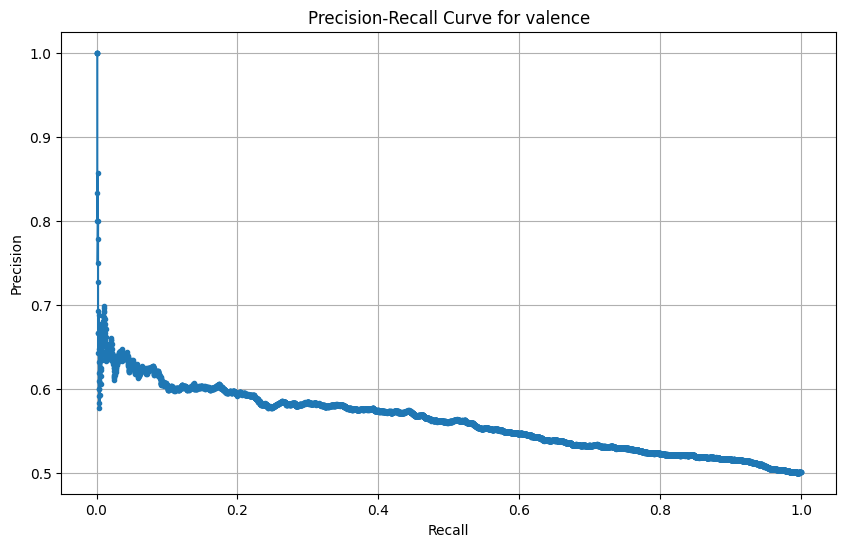

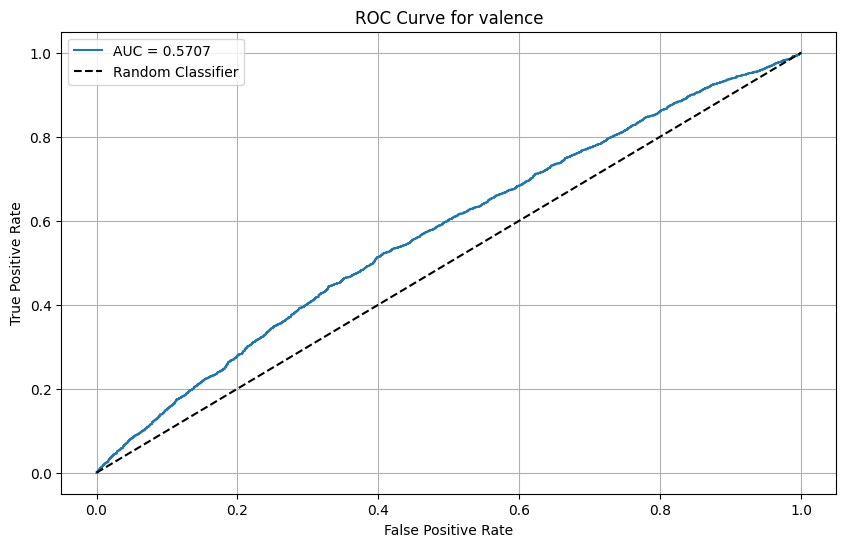

=== Results for valence ===
Average F1: 0.5069
Average Accuracy: 0.5557
Average Precision: 0.5568
Average Recall: 0.5535
Average ROC-AUC: 0.5707
Average True Negative: 209.0000
Average False Positive: 151.6000
Average False Negative: 169.0000
Average True Positive: 192.0000


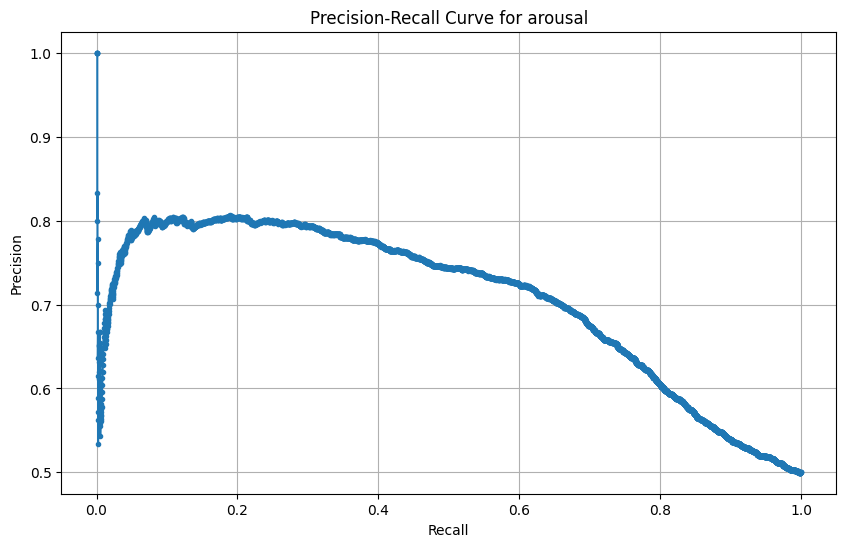

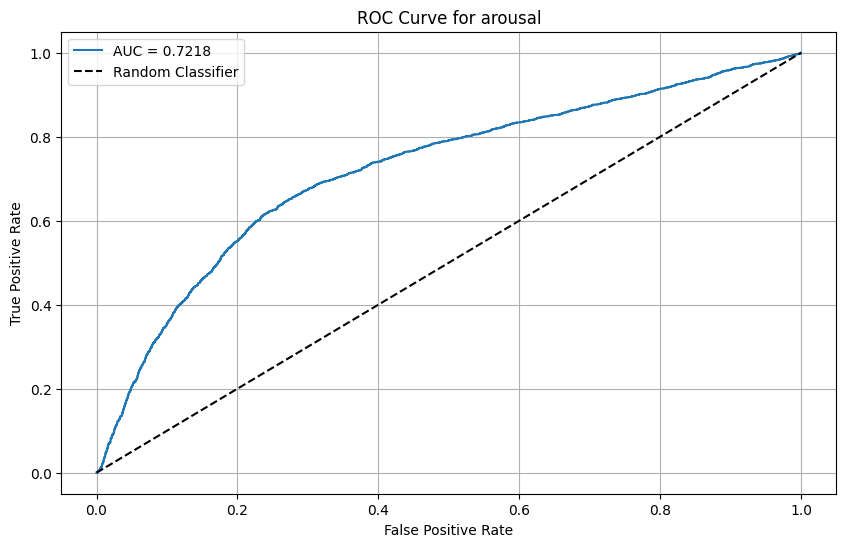

=== Results for arousal ===
Average F1: 0.6608
Average Accuracy: 0.6881
Average Precision: 0.6986
Average Recall: 0.6598
Average ROC-AUC: 0.7218
Average True Negative: 265.6000
Average False Positive: 95.2000
Average False Negative: 129.9000
Average True Positive: 230.9000


In [ ]:



def classification_model_evaluation(X, y, groups, name, rfe_features=10, splits=10, results_path="binary_results.csv"):
    results, y_val_all, y_pred_all, y_proba_all = run_binary_classification(
        X,
        y,
        groups,
        rfe_features=rfe_features,
        splits=splits,
        results_path=results_path
    )

    import numpy as np

    y_val_all_flat = np.concatenate(y_val_all)
    y_proba_all_flat = np.concatenate([proba[:, 1] for proba in y_proba_all])

    precision_curve, recall_curve, _ = precision_recall_curve(y_val_all_flat, y_proba_all_flat)
    plt.figure(figsize=(10, 6))
    plt.plot(recall_curve, precision_curve, marker='.')
    plt.title(f'Precision-Recall Curve for {name}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    plt.show()

    roc_auc = roc_auc_score(y_val_all_flat, y_proba_all_flat)
    fpr, tpr, _ = roc_curve(y_val_all_flat, y_proba_all_flat)

    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
    plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {name}')
    plt.legend()
    plt.grid(True)
    plt.show()

    avg_f1 = results["F1"].mean()
    avg_acc = results["Accuracy"].mean()
    avg_precision = results["Precision"].mean()
    avg_recall = results["Recall"].mean()
    avg_tn = results["True Negative"].mean()
    avg_fp = results["False Positive"].mean()
    avg_fn = results["False Negative"].mean()
    avg_tp = results["True Positive"].mean()

    print(f'=== Results for {name} ===')
    print(f"Average F1: {avg_f1:.4f}")
    print(f"Average Accuracy: {avg_acc:.4f}")
    print(f"Average Precision: {avg_precision:.4f}")
    print(f"Average Recall: {avg_recall:.4f}")
    print(f"Average ROC-AUC: {roc_auc:.4f}")
    print(f"Average True Negative: {avg_tn:.4f}")
    print(f"Average False Positive: {avg_fp:.4f}")
    print(f"Average False Negative: {avg_fn:.4f}")
    print(f"Average True Positive: {avg_tp:.4f}")

classification_model_evaluation(X_binary, y_valence_binary, groups_binary, "valence", rfe_features=15, splits=10, results_path="valence_binary_results.csv")
classification_model_evaluation(X_binary, y_arousal_binary, groups_binary, "arousal", rfe_features=15, splits=10, results_path="arousal_binary_results.csv")


<div class="alert alert-block alert-success">

## Classification Evaluation Metrics

The classification performance was evaluated using multiple metrics including **F1 Score**, **Accuracy**, **Precision**, **Recall**, **ROC-AUC**, and **confusion matrix components**. Evaluation was conducted using **StratifiedGroupKFold** to ensure participant-independent validation. Both **precision-recall** and **ROC curves** were plotted to assess discriminative ability and decision confidence, with results reported separately for arousal and valence.

### Arousal Classification

**F1 Score**
- F1 = **0.6608** indicates strong balance between precision and recall.
- This shows that the model is effectively identifying high-arousal states while minimizing false predictions.

**Accuracy**
- Accuracy = **0.6881**, well above random baseline (0.5), confirming solid classification performance.

**Precision & Recall**
- Precision = **0.6986**, Recall = **0.6598** show that most predicted positives are correct, and most true positives are successfully detected.

**ROC-AUC**
- AUC = **0.7218**, indicating good class separability.
- The ROC curve shows consistent advantage over random classification, with good early separation.

**PR Curve**
- The precision-recall curve has a high area under the curve, reflecting strong confidence in predictions across thresholds.

**Confusion Matrix (avg)**
- TN: 265.6, FP: 95.2, FN: 129.9, TP: 230.9
- False positives are kept relatively low; true positives dominate, confirming good positive class recognition.

#### Summary
The model demonstrates strong discriminative power on arousal. ROC and PR curves validate robust prediction quality. Both precision and recall are consistently high, and performance generalizes across participants.

---

### Valence Classification

**F1 Score**
- F1 = **0.5069**, only slightly above the random baseline, suggesting marginal signal.

**Accuracy**
- Accuracy = **0.5557** shows weak classification ability, not much better than a naive classifier.

**Precision & Recall**
- Precision = **0.5568**, Recall = **0.5535** indicate weak and nearly symmetric prediction performance across classes.

**ROC-AUC**
- AUC = **0.5707**, only slightly above chance, indicating limited separability of the two classes.

**PR Curve**
- The precision-recall curve shows a steep drop-off, and low area under the curve — typical of low signal-to-noise conditions.

**Confusion Matrix (avg)**
- TN: 209.0, FP: 151.6, FN: 169.0, TP: 192.0
- Nearly symmetric false positives and false negatives highlight weak decision boundaries.

#### Summary
The classifier performs only slightly better than random for valence, with weak ROC and PR curve structures. These results are consistent with known challenges in acoustic modeling of valence, which is often subjective and less physically manifest in speech.

---

### Overall Observations
- **Arousal classification** is strong, with ROC-AUC > 0.72, high F1, and well-shaped PR and ROC curves.
- **Valence classification** performs near baseline; results suggest weak underlying structure in acoustic features for this task.
- These findings reinforce literature trends: **arousal is easier to model acoustically than valence** due to its more overt and energetic vocal cues.

</div>


In [ ]:
# Final model training on full dataset
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

# Select the same number of features and estimator
final_estimator_valance = LogisticRegression(max_iter=1000)
rfe = RFE(final_estimator_valance, n_features_to_select=10)

# Train RFE with Logistic Regression on full dataset
rfe.fit(X_binary, df_binary_clean['valence_binary'])
y_pred = rfe.predict(X_binary)

# Evaluate the final model
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
print("Final Model Evaluation:")
print(classification_report(df_binary_clean['valence_binary'], y_pred))
print(f"Accuracy: {accuracy_score(df_binary_clean['valence_binary'], y_pred):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(df_binary_clean['valence_binary'], y_pred))

# Your final model is now stored in `rfe`
# You can save it with joblib or pickle
import joblib
joblib.dump(rfe, "final_model_valence.pkl")


final_estimator_arousal = LogisticRegression(max_iter=1000)
rfe_arousal = RFE(final_estimator_arousal, n_features_to_select=10)

# Train RFE with Logistic Regression on full dataset
rfe_arousal.fit(X_binary, df_binary_clean['arousal_binary'])
y_pred_arousal = rfe_arousal.predict(X_binary)

# Evaluate the final model
print("Final Model Evaluation for Arousal:")
print(classification_report(df_binary_clean['arousal_binary'], y_pred_arousal))
print(f"Accuracy: {accuracy_score(df_binary_clean['arousal_binary'], y_pred_arousal):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(df_binary_clean['arousal_binary'], y_pred_arousal))

# Save the final model for arousal
joblib.dump(rfe_arousal, "final_model_arousal.pkl")


Final Model Evaluation:
              precision    recall  f1-score   support

           0       0.58      0.63      0.60      3619
           1       0.60      0.55      0.57      3619

    accuracy                           0.59      7238
   macro avg       0.59      0.59      0.59      7238
weighted avg       0.59      0.59      0.59      7238

Accuracy: 0.5893
Confusion Matrix:
[[2273 1346]
 [1627 1992]]
Final Model Evaluation for Arousal:
              precision    recall  f1-score   support

           0       0.68      0.74      0.71      3619
           1       0.71      0.65      0.68      3619

    accuracy                           0.69      7238
   macro avg       0.69      0.69      0.69      7238
weighted avg       0.69      0.69      0.69      7238

Accuracy: 0.6934
Confusion Matrix:
[[2665  954]
 [1265 2354]]


['final_model_arousal.pkl']

<div class="alert alert-block alert-info">

### Emotions are inherently subjective, which can introduce bias during the annotation of affect datasets. One way to mitigate or reduce this subjectivity bias is to formulate affect modelling as a ranking problem. To achieve this, continuous arousal/valence labels are discretised into “high,” “medium,” and “low” categories.

#### Select and justify appropriate threshold values for discretising (“high”, “neutral”,“low”) both arousal and valence annotations (the threshold for discretising arousalshould not necessarily be equal to the threshold for discretising valence).
#### Implement a ranking predictive model for each response variable.
#### Select appropriate metrics to evaluate the performance of the models in this scenario using the validation protocol you proposed in Task 1.

</div>

## Tao cuts


'mean_arousal and 'mean_valance' will be mapped into corresponding ordinal variables with three levels:

- Low
- Neutral
- High

Given the subjective and continuous nature of valence and arousal, the Tao cuts method will be used where  thresholds separating the lower, middle, and upper parts of the distribution are defined.

This partitioning scheme gives complete control over class distribution. It was selected as given the sugjectivity of response variables, neutral states may be prevalent and a more detailed modeling of the extremes may be required.

In [115]:
df_rank = df_raw.copy()

LOW_PROPORTION_VALANCE = 0.2
NEUTRAL_PROPORTION_VALANCE = 0.5

# valance ranking

low_threshold = df_rank['median_valence'].quantile(LOW_PROPORTION_VALANCE)
neutral_threshold = df_rank['median_valence'].quantile(LOW_PROPORTION_VALANCE + NEUTRAL_PROPORTION_VALANCE)

df_rank['median_valence_level'] = pd.cut(
    df_rank['median_valence'],
    bins=[-np.inf, low_threshold, neutral_threshold, np.inf],
    labels=["low", "neutral", "high"]
)

print(f"Valence thresholds: {low_threshold:.4f}, {neutral_threshold:.4f}")
print(df_rank['median_valence_level'].value_counts())


LOW_PROPORTION_AROUSAL = 0.2
NEUTRAL_PROPORTION_AROUSAL = 0.5
# arousal ranking
low_threshold = df_rank['median_arousal'].quantile(LOW_PROPORTION_AROUSAL)
neutral_threshold = df_rank['median_arousal'].quantile(LOW_PROPORTION_AROUSAL + NEUTRAL_PROPORTION_AROUSAL)
df_rank['median_arousal_level'] = pd.cut(
    df_rank['median_arousal'],
    bins=[-np.inf, low_threshold, neutral_threshold, np.inf],
    labels=["low", "neutral", "high"]
)

print(f"Arousal thresholds: {low_threshold:.4f}, {neutral_threshold:.4f}")
print(df_rank['median_arousal_level'].value_counts())

df_rank.to_csv("df_rank.csv", index=False)


Valence thresholds: -0.0084, 0.1286
median_valence_level
neutral    3619
high       2171
low        1448
Name: count, dtype: int64
Arousal thresholds: -0.1515, 0.1292
median_arousal_level
neutral    3617
high       2172
low        1449
Name: count, dtype: int64


<div class="alert alert-block alert-info">

## Task 3

### In this task, you will identify similar observations captured from the first participant (participant ID = 1). Complete the following steps:

#### Create groups of similar observations from the first participant by proposing and implementing two suitable algorithms.
#### Evaluate the clusters quality using appropriate metrics.
#### Compare the algorithms you implemented and select the best one.
#### Create visualisations for the clustering results.
#### How would you assign a new observation from the first participant to an existing group?

</div>

In [116]:
df_cluster = df_raw.copy()
df_participant_1 = df_cluster[df_cluster['Participant'] == 1]
print(f'participant 1 records: {df_participant_1.shape}')

# drop targets and 
X_cluster = df_participant_1.drop(columns=['Participant', 'median_arousal', 'median_valence'])



participant 1 records: (725, 133)


Number of components to retain 95% variance: 35


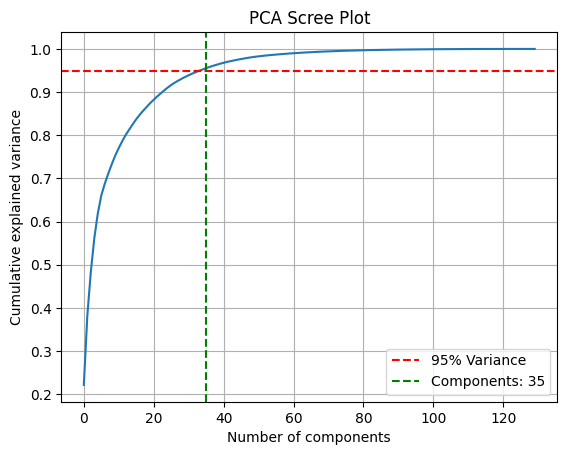

In [117]:
from sklearn.decomposition import PCA

explained_variance = 0.95

pca = PCA().fit(X_cluster)

num_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= explained_variance) + 1
print(f"Number of components to retain {explained_variance*100:.0f}% variance: {num_components}")

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.axhline(y=explained_variance, color='r', linestyle='--', label=f'{explained_variance*100:.0f}% Variance')
plt.axvline(x=num_components, color='g', linestyle='--', label=f'Components: {num_components}')
plt.legend()
plt.grid()
plt.title('PCA Scree Plot')
plt.show()

In [118]:
pca = PCA(n_components=35)
X_cluster_pca = pca.fit_transform(X_cluster)

In [119]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(X_cluster_pca)

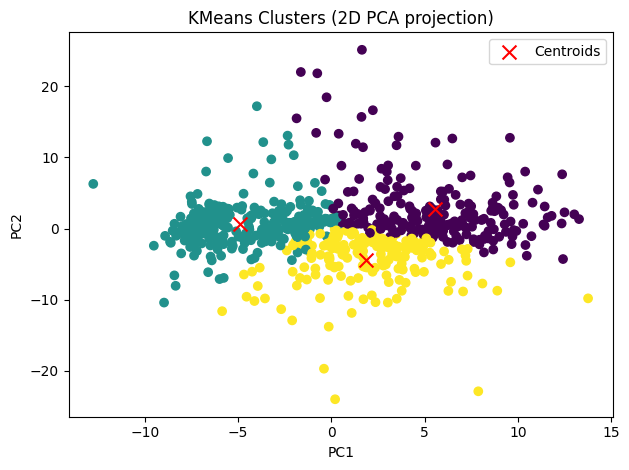

In [120]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca_vis = PCA(n_components=2)
X_vis = pca_vis.fit_transform(X_cluster_pca)  # or X_scaled if you prefer



plt.scatter(X_vis[:, 0], X_vis[:, 1], c=kmeans_labels, cmap='viridis')
plt.title("KMeans Clusters (2D PCA projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")


centroids = kmeans.cluster_centers_
centroids_vis = pca_vis.transform(centroids)
plt.scatter(centroids_vis[:, 0], centroids_vis[:, 1], c='red', marker='x', s=100, label='Centroids')
plt.legend()

plt.tight_layout()




plt.show()


        median_arousal                               median_valence            \
                  mean       std       min       max           mean       std   
cluster                                                                         
0             0.046561  0.132243 -0.267933  0.269200       0.131240  0.076053   
1             0.019071  0.163683 -0.431800  0.335926       0.099440  0.064946   
2             0.122299  0.112045 -0.225800  0.326842       0.125898  0.058951   

                             
              min       max  
cluster                      
0       -0.029067  0.417533  
1       -0.022733  0.394067  
2       -0.030200  0.246133  


C:\Users\carme\AppData\Local\Temp\ipykernel_24292\1975756301.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_participant_1['cluster'] = kmeans_labels


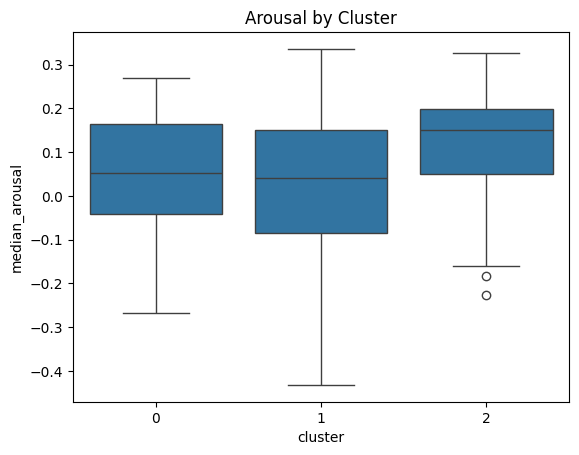

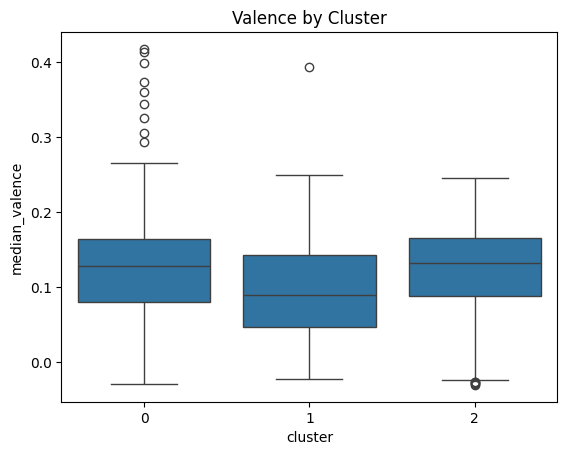

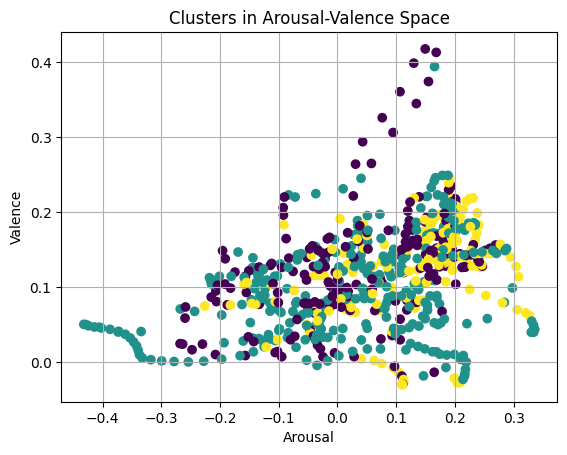

In [121]:
df_participant_1['cluster'] = kmeans_labels

cluster_stats = df_participant_1.groupby('cluster')[['median_arousal', 'median_valence']].agg(['mean', 'std', 'min', 'max'])
print(cluster_stats)


import seaborn as sns

sns.boxplot(x='cluster', y='median_arousal', data=df_participant_1)
plt.title("Arousal by Cluster")
plt.show()

sns.boxplot(x='cluster', y='median_valence', data=df_participant_1)
plt.title("Valence by Cluster")
plt.show()

plt.scatter(df_participant_1['median_arousal'], df_participant_1['median_valence'], c=df_participant_1['cluster'], cmap='viridis')
plt.xlabel("Arousal")
plt.ylabel("Valence")
plt.title("Clusters in Arousal-Valence Space")
plt.grid()
plt.show()


In [122]:
from sklearn.cluster import AgglomerativeClustering

# Set number of clusters (you can experiment or infer from dendrogram)
model = AgglomerativeClustering(n_clusters=3, linkage='ward')  # 'ward' uses variance minimization
labels = model.fit_predict(X_cluster_pca)  # Or X_scaled if not using PCA

# Add labels to your DataFrame
df_participant_1['hclust'] = labels

C:\Users\carme\AppData\Local\Temp\ipykernel_24292\2983288578.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_participant_1['hclust'] = labels


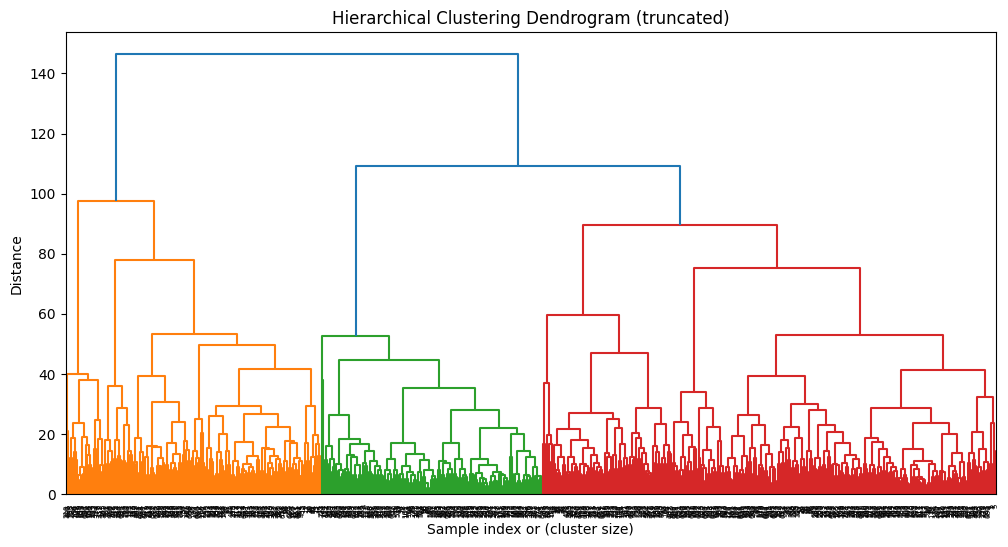

In [123]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

# Compute linkage matrix
linkage_matrix = sch.linkage(X_cluster_pca, method='ward')

# Plot dendrogram
plt.figure(figsize=(12, 6))
sch.dendrogram(linkage_matrix, truncate_mode='level', p=25)
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('Sample index or (cluster size)')
plt.ylabel('Distance')
plt.show()

In [124]:
from scipy.cluster.hierarchy import fcluster

# Choose threshold (height to cut dendrogram)
labels_cut = fcluster(linkage_matrix, t=10, criterion='distance')
df_participant_1['hclust_cut'] = labels_cut

C:\Users\carme\AppData\Local\Temp\ipykernel_24292\349798008.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_participant_1['hclust_cut'] = labels_cut


In [125]:
from sklearn.metrics import silhouette_score

score = silhouette_score(X_cluster_pca, df_participant_1['hclust_cut'])
print(f"Silhouette Score: {score:.2f}")

Silhouette Score: 0.12


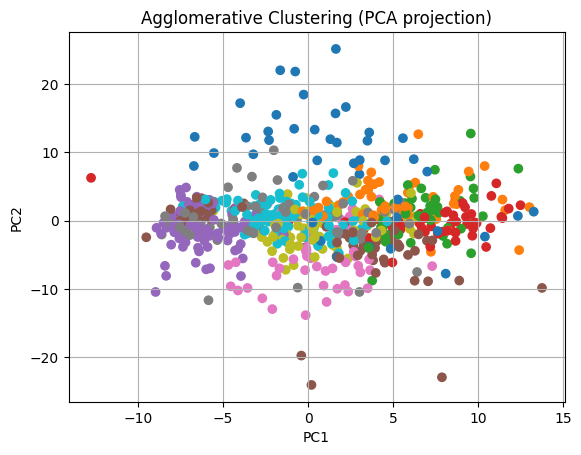

In [126]:
plt.scatter(X_cluster_pca[:, 0], X_cluster_pca[:, 1], c=df_participant_1['hclust_cut'], cmap='tab10')
plt.title("Agglomerative Clustering (PCA projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid()
plt.show()

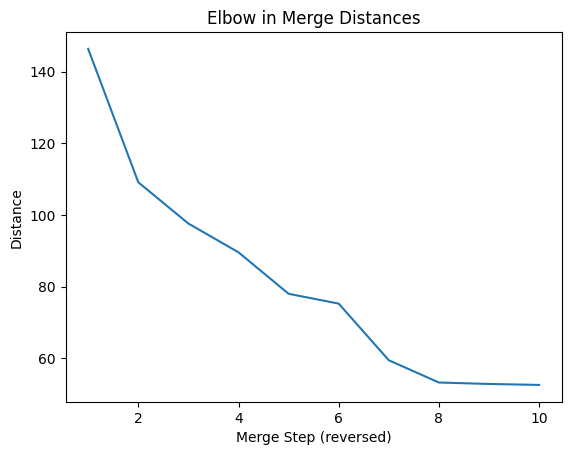

In [127]:
last = linkage_matrix[-10:, 2]  # last 10 merge distances
plt.plot(range(1, 11), last[::-1])
plt.xlabel('Merge Step (reversed)')
plt.ylabel('Distance')
plt.title('Elbow in Merge Distances')
plt.show()

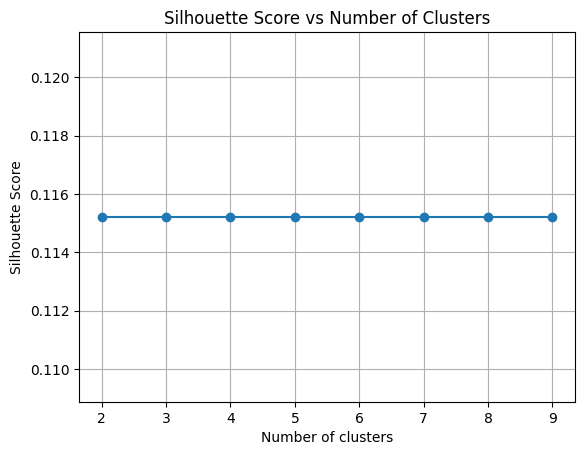

In [128]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering

scores = []
ks = range(2, 10)

for k in ks:
    model = AgglomerativeClustering(n_clusters=k)
    labels = model.fit_predict(X_cluster_pca)
    score = silhouette_score(X_cluster_pca, df_participant_1['hclust_cut'])
    scores.append(score)

plt.plot(ks, scores, marker='o')
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs Number of Clusters")
plt.grid()
plt.show()


<div class="alert alert-block alert-info">

## Task 4

### Based on the results obtained from Task 3:

#### Explain whether the clustering information could be used to build more accurate models for Task 2 and describe what you would do to build such models.

</div>